# EFIMM0141: Data Analytics in Business
> Group Assignment - Stock Price Prediction

## Import Required Libraries

In [1]:
# Standard Library Imports
import time
import random
import warnings
warnings.filterwarnings("ignore")

# Data Manipulation
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
from IPython.display import SVG, Image

# Financial Data
import yfinance as yf

# Technical Analysis
import talib
import quantstats as qs

# Time Series Analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

# Machine Learning
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, BatchNormalization, Input,
    Attention, Concatenate, Flatten
)
from tensorflow.keras.callbacks import (
    EarlyStopping, Callback, ModelCheckpoint
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.utils import plot_model, model_to_dot

# Keras Tuner for Hyperparameter Optimization
import keras_tuner as kt
from keras.models import Model
from keras.layers import Input, Dense, LSTM
from keras.constraints import MinMaxNorm

# Set Random Seeds for Reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Part 1: Get Data from yfinance

In [2]:
# Define time period and interval
time_period='2y'
time_interval='1h'

In [3]:
# Fetching Apple Inc.
apple = yf.download('AAPL',period=time_period, interval=time_interval)
apple['Adj_close'] = apple['Adj Close']
apple = apple.drop(columns=['Adj Close'])
apple

[*********************100%***********************]  1 of 1 completed


Close        High         Low        Open  \
Datetime                                                                    
2022-10-26 13:30:00+00:00  150.660004  151.320007  149.529999  150.960007   
2022-10-26 14:30:00+00:00  151.470001  151.770004  150.300003  150.604004   
2022-10-26 15:30:00+00:00  151.529999  151.990005  151.369995  151.470001   
2022-10-26 16:30:00+00:00  149.479996  151.919998  149.440002  151.520004   
2022-10-26 17:30:00+00:00  148.250000  149.520004  148.039993  149.489899   
...                               ...         ...         ...         ...   
2024-10-25 15:30:00+00:00  232.710007  232.731995  231.759995  232.229996   
2024-10-25 16:30:00+00:00  231.857498  232.940002  231.529999  232.735001   
2024-10-25 17:30:00+00:00  231.839996  231.971497  231.070007  231.830002   
2024-10-25 18:30:00+00:00  231.619995  232.199997  231.369995  231.846893   
2024-10-25 19:30:00+00:00  231.399994  231.800003  231.110001  231.649994   

                             Volume   Adj_close  
Datetime                                         
2022-10-26 13:30:00+00:00  22487941  150.660004  
2022-10-26 14:30:00+00:00   9744837  151.470001  
2022-10-26 15:30:00+00:00   7818754  151.529999  
2022-10-26 16:30:00+00:00   9341974  149.479996  
2022-10-26 17:30:00+00:00   9690025  148.250000  
...                             ...         ...  
2024-10-25 15:30:00+00:00   3211126  232.710007  
2024-10-25 16:30:00+00:00   2367087  231.857498  
2024-10-25 17:30:00+00:00   2818009  231.839996  
2024-10-25 18:30:00+00:00   2642893  231.619995  
2024-10-25 19:30:00+00:00   3572932  231.399994  

[3505 rows x 6 columns]

In [4]:
# Fetching NASDAQ-100 (a major tech index)
nasdaq_data = yf.download('^NDX', period=time_period, interval=time_interval)
nasdaq_data['NASDAQ_close'] = nasdaq_data['Close']
nasdaq_data = nasdaq_data[['NASDAQ_close']]
nasdaq_data

[*********************100%***********************]  1 of 1 completed


NASDAQ_close
Datetime                               
2022-10-26 13:30:00+00:00  11532.609375
2022-10-26 14:30:00+00:00  11636.208984
2022-10-26 15:30:00+00:00  11595.045898
2022-10-26 16:30:00+00:00  11444.053711
2022-10-26 17:30:00+00:00  11437.323242
...                                 ...
2024-10-25 15:30:00+00:00  20511.517578
2024-10-25 16:30:00+00:00  20425.835938
2024-10-25 17:30:00+00:00  20392.525391
2024-10-25 18:30:00+00:00  20370.580078
2024-10-25 19:30:00+00:00  20352.699219

[3505 rows x 1 columns]

In [5]:
# Fetching Technology Select Sector SPDR Fund (XLK)
tech_etf_data = yf.download('XLK', period=time_period, interval=time_interval)
tech_etf_data['XLK_close'] = tech_etf_data['Close']
tech_etf_data = tech_etf_data[['XLK_close']]
tech_etf_data

[*********************100%***********************]  1 of 1 completed


XLK_close
Datetime                             
2022-10-26 13:30:00+00:00  126.690002
2022-10-26 14:30:00+00:00  127.910004
2022-10-26 15:30:00+00:00  127.540001
2022-10-26 16:30:00+00:00  125.860001
2022-10-26 17:30:00+00:00  125.830002
...                               ...
2024-10-25 15:30:00+00:00  232.460007
2024-10-25 16:30:00+00:00  231.229996
2024-10-25 17:30:00+00:00  230.889893
2024-10-25 18:30:00+00:00  230.660004
2024-10-25 19:30:00+00:00  230.330002

[3505 rows x 1 columns]

In [6]:
# Fetching TSMC data
tsmc_data = yf.download('TSM', period=time_period, interval=time_interval)
tsmc_data['TSMC_close'] = tsmc_data['Close']
tsmc_data = tsmc_data[['TSMC_close']]
tsmc_data

[*********************100%***********************]  1 of 1 completed


TSMC_close
Datetime                             
2022-10-26 13:30:00+00:00   61.580002
2022-10-26 14:30:00+00:00   61.744999
2022-10-26 15:30:00+00:00   61.740002
2022-10-26 16:30:00+00:00   60.895000
2022-10-26 17:30:00+00:00   61.185001
...                               ...
2024-10-25 15:30:00+00:00  204.619995
2024-10-25 16:30:00+00:00  204.050003
2024-10-25 17:30:00+00:00  204.190002
2024-10-25 18:30:00+00:00  203.809998
2024-10-25 19:30:00+00:00  203.389999

[3505 rows x 1 columns]

In [7]:
merged_df = pd.merge(apple, nasdaq_data, on='Datetime', how='left')
merged_df = pd.merge(merged_df, tech_etf_data, on='Datetime', how='left')
merged_df = pd.merge(merged_df, tsmc_data, on='Datetime', how='left')

# Display the merged dataframe
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2022-10-26 13:30:00+00:00 to 2024-10-25 19:30:00+00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         3505 non-null   float64
 1   High          3505 non-null   float64
 2   Low           3505 non-null   float64
 3   Open          3505 non-null   float64
 4   Volume        3505 non-null   int64  
 5   Adj_close     3505 non-null   float64
 6   NASDAQ_close  3505 non-null   float64
 7   XLK_close     3505 non-null   float64
 8   TSMC_close    3505 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 273.8 KB


In [8]:
# Fetching VIX data
vix_data = yf.download('^VIX', period=time_period, interval=time_interval)
vix_data['VIX_close'] = vix_data[['Close']]
vix_data = vix_data[['VIX_close']]
vix_data

[*********************100%***********************]  1 of 1 completed


VIX_close
Datetime                            
2022-10-26 07:00:00+00:00  28.400000
2022-10-26 08:00:00+00:00  28.299999
2022-10-26 09:00:00+00:00  28.400000
2022-10-26 10:00:00+00:00  28.450001
2022-10-26 11:00:00+00:00  28.400000
...                              ...
2024-10-25 16:00:00+00:00  18.870001
2024-10-25 17:00:00+00:00  20.080000
2024-10-25 18:00:00+00:00  19.530001
2024-10-25 19:00:00+00:00  20.200001
2024-10-25 20:00:00+00:00  20.340000

[7021 rows x 1 columns]

In [9]:
# Adjust the 'Datetime' in vix_data (adding 30 minutes)
vix_data.index = vix_data.index + pd.Timedelta(minutes=30)

# Merge vix_data with merged_df on 'Datetime'
merged_df = pd.merge(merged_df, vix_data, how='left', on='Datetime')

# Display the updated merged dataframe info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2022-10-26 13:30:00+00:00 to 2024-10-25 19:30:00+00:00
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         3505 non-null   float64
 1   High          3505 non-null   float64
 2   Low           3505 non-null   float64
 3   Open          3505 non-null   float64
 4   Volume        3505 non-null   int64  
 5   Adj_close     3505 non-null   float64
 6   NASDAQ_close  3505 non-null   float64
 7   XLK_close     3505 non-null   float64
 8   TSMC_close    3505 non-null   float64
 9   VIX_close     3505 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 301.2 KB


In [10]:
# Fetching 13-week Treasury bill yield data
yields = yf.download('^IRX', period=time_period, interval=time_interval)
yields['IRX_close'] = yields[['Close']]
yields = yields[['IRX_close']]
yields

[*********************100%***********************]  1 of 1 completed


IRX_close
Datetime                            
2022-10-26 12:20:00+00:00      3.963
2022-10-26 13:20:00+00:00      3.960
2022-10-26 14:20:00+00:00      3.945
2022-10-26 15:20:00+00:00      3.913
2022-10-26 16:20:00+00:00      3.910
...                              ...
2024-10-25 14:20:00+00:00      4.498
2024-10-25 15:20:00+00:00      4.500
2024-10-25 16:20:00+00:00      4.500
2024-10-25 17:20:00+00:00      4.508
2024-10-25 18:20:00+00:00      4.510

[3521 rows x 1 columns]

In [11]:
# Shift the 'yields' DataFrame index by 10 minutes forward to align with 'AAPL'
yields.index = yields.index + pd.Timedelta(minutes=10)

# Merge the two DataFrames
data = pd.merge_asof(merged_df, yields, left_index=True, right_index=True, direction='backward')

# Display the merged dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2022-10-26 13:30:00+00:00 to 2024-10-25 19:30:00+00:00
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         3505 non-null   float64
 1   High          3505 non-null   float64
 2   Low           3505 non-null   float64
 3   Open          3505 non-null   float64
 4   Volume        3505 non-null   int64  
 5   Adj_close     3505 non-null   float64
 6   NASDAQ_close  3505 non-null   float64
 7   XLK_close     3505 non-null   float64
 8   TSMC_close    3505 non-null   float64
 9   VIX_close     3505 non-null   float64
 10  IRX_close     3505 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 328.6 KB


In [12]:
def calculate_indicators_hourly(df):
    # Ensure all necessary columns are floats for TA-Lib compatibility
    for column in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj_close']:
        df[column] = df[column].astype(float)

    # Relative Strength Index (RSI)
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)

    # Average Directional Index (ADX)
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)

    # Average True Range (ATR)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    
    # Bollinger Bands Width
    upperband, middleband, lowerband = talib.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BB_width'] = (upperband - lowerband) / middleband

    # Volume Weighted Average Price (VWAP)
    df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum() 

    # Intraday Momentum Index (IMI)
    positive = np.where(df['Close'] > df['Open'], df['Close'] - df['Open'], 0)
    negative = np.where(df['Close'] < df['Open'], df['Open'] - df['Close'], 0)
    # Calculate SMA for positive and negative values over the period
    sum_positive = talib.SMA(positive, timeperiod=14)
    sum_negative = talib.SMA(negative, timeperiod=14)
    # Calculate IMI
    df['IMI'] = 100 * (sum_positive / (sum_positive + sum_negative))
    
    # Drop rows with NaN values resulting from indicator calculations
    df = df.dropna()

    return df

# Apply the adjusted indicator calculation for hourly data
data = calculate_indicators_hourly(data)

In [13]:
# Drop NaN rows
data = data.dropna()

# Reset index (Convert the datetime index to a column)
data.reset_index(inplace=True)

# Clean time zone (remove time zone info from 'Datetime' column)
data['Datetime'] = data['Datetime'].dt.tz_localize(None)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3478 entries, 0 to 3477
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Datetime      3478 non-null   datetime64[ns]
 1   Close         3478 non-null   float64       
 2   High          3478 non-null   float64       
 3   Low           3478 non-null   float64       
 4   Open          3478 non-null   float64       
 5   Volume        3478 non-null   float64       
 6   Adj_close     3478 non-null   float64       
 7   NASDAQ_close  3478 non-null   float64       
 8   XLK_close     3478 non-null   float64       
 9   TSMC_close    3478 non-null   float64       
 10  VIX_close     3478 non-null   float64       
 11  IRX_close     3478 non-null   float64       
 12  RSI           3478 non-null   float64       
 13  ADX           3478 non-null   float64       
 14  ATR           3478 non-null   float64       
 15  BB_width      3478 non-null   float64 

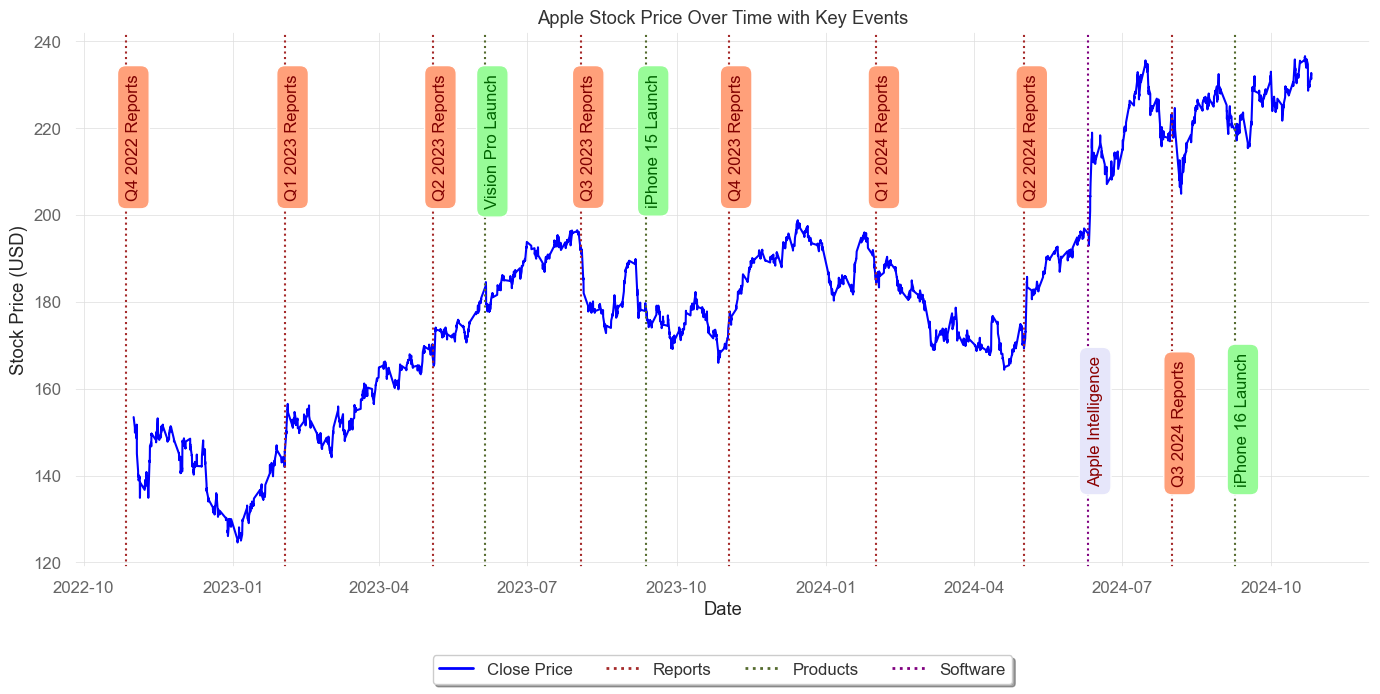

In [14]:
# Ensure the data is sorted by date
data.sort_values('Datetime', inplace=True)

# Define the event dates and details
events = [
    {'date': '2022-10-27', 'label': 'Q4 2022 Reports'},  
    {'date': '2023-02-02', 'label': 'Q1 2023 Reports'},
    {'date': '2023-05-04', 'label': 'Q2 2023 Reports'},
    {'date': '2023-06-05', 'label': 'Vision Pro Launch'},
    {'date': '2023-08-03', 'label': 'Q3 2023 Reports'},
    {'date': '2023-09-12', 'label': 'iPhone 15 Launch'},
    {'date': '2023-11-02', 'label': 'Q4 2023 Reports'},
    {'date': '2024-02-01', 'label': 'Q1 2024 Reports'},
    {'date': '2024-05-02', 'label': 'Q2 2024 Reports'},
    {'date': '2024-06-10', 'label': 'Apple Intelligence'},
    {'date': '2024-08-01', 'label': 'Q3 2024 Reports'},
    {'date': '2024-09-09', 'label': 'iPhone 16 Launch'},
]

# Convert event dates to datetime objects, handling incomplete dates
for event in events:
    try:
        event['datetime'] = pd.to_datetime(event['date'])
    except ValueError:
        # Handle dates with unknown day
        event['datetime'] = pd.NaT

# Filter out events with unknown dates
events = [event for event in events if not pd.isna(event['datetime'])]

# Define color mapping based on event type
def get_event_colors(label):
    if 'Reports' in label:
        return {
            'line_color': 'brown',
            'text_color': 'maroon',
            'bbox_color': 'lightsalmon'
        }
    elif 'Launch' in label:
        return {
            'line_color': 'darkolivegreen',
            'text_color': 'darkgreen',
            'bbox_color': 'palegreen'
        }
    else:
        return {
            'line_color': 'purple',
            'text_color': 'darkred',
            'bbox_color': 'lavender'
        }

# Create the plot
plt.figure(figsize=(14, 7))
plt.plot(data['Datetime'], data['Close'], label='Close Price', color='blue')

# Get current y-axis limits
y_min, y_max = plt.ylim()

# Initialize legend elements with only the Close Price
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Close Price')
]

# Add vertical lines and annotations for each event
for event in events:
    colors = get_event_colors(event['label'])
    
    # Draw a vertical dashed line for the event
    plt.axvline(x=event['datetime'], color=colors['line_color'], linestyle=':', alpha=1.0)
    
    # Determine annotation position based on the event
    if event['label'] in ['Apple Intelligence', 'Q3 2024 Reports', 'iPhone 16 Launch']:
        # Place these events below the plot
        y_position = y_min + (y_max - y_min) * 0.15  # 15% above the bottom
        vertical_alignment = 'bottom'
    else:
        # Place other events above the plot
        y_position = y_max * 0.96  # 96% of the y-axis
        vertical_alignment = 'top'
    
    # Annotate the event
    plt.text(
        event['datetime'], 
        y_position, 
        event['label'],
        rotation=90, 
        verticalalignment=vertical_alignment, 
        fontsize=12, 
        color=colors['text_color'],
        bbox=dict(boxstyle="round,pad=0.5", fc=colors['bbox_color'], alpha=1.0)
    )
    
    # Add to legend if not already present
    if 'Reports' in event['label']:
        legend_elements.append(Line2D([0], [0], color=colors['line_color'], linestyle=':', lw=2, label='Reports'))
    elif 'Launch' in event['label']:
        legend_elements.append(Line2D([0], [0], color=colors['line_color'], linestyle=':', lw=2, label='Products'))
    else:
        legend_elements.append(Line2D([0], [0], color=colors['line_color'], linestyle=':', lw=2, label='Software'))

# To avoid duplicate labels in the legend, create a unique set
unique_labels = {}
for element in legend_elements:
    if element.get_label() not in unique_labels:
        unique_labels[element.get_label()] = element

# Recreate the legend with unique labels and position it below the plot
plt.legend(handles=list(unique_labels.values()), loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=10)

# Adjust the layout to make room for the legend
plt.subplots_adjust(bottom=0.25)  # Increase bottom margin to accommodate legend

# Customize the plot
plt.title('Apple Stock Price Over Time with Key Events')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
# # Save Datasets
# train.to_csv('Data/apple_train_data.csv', index=False)
# test.to_csv('Data/apple_test_data.csv', index=False)

## Part 2: Exploratory Data Analysis

In [16]:
# Split data into 90% training and 10% testing
train_size = int(len(data) * 0.9)
eda_train, eda_test = data[:train_size], data[train_size:]

# Show the shapes of training and testing sets
print(f"Training set: {eda_train.shape}")
print(f"Testing set: {eda_test.shape}")

Training set: (3130, 18)
Testing set: (348, 18)


In [17]:
# Descriptive statistics
eda_train.describe(include='all')

Datetime        Close         High          Low  \
count                           3130  3130.000000  3130.000000  3130.000000   
mean   2023-09-25 00:02:19.169328896   176.466789   177.015488   175.879302   
min              2022-10-31 19:30:00   124.570000   124.940002   124.169998   
25%              2023-04-14 14:45:00   164.630329   165.009998   164.255997   
50%              2023-09-25 17:00:00   177.566704   178.045006   177.080002   
75%              2024-03-06 20:15:00   189.940071   190.315006   189.562504   
max              2024-08-16 14:30:00   235.600006   237.229996   234.619995   
std                              NaN    22.592289    22.617174    22.551412   

              Open        Volume    Adj_close  NASDAQ_close    XLK_close  \
count  3130.000000  3.130000e+03  3130.000000   3130.000000  3130.000000   
mean    176.445507  7.366677e+06   176.466789  15377.714219   175.010109   
min     124.578003  0.000000e+00   124.570000  10666.228516   118.669998   
25%     164.605003  4.493235e+06   164.630329  13014.204346   148.363747   
50%     177.525002  5.885026e+06   177.566704  15256.353516   172.424995   
75%     189.937500  8.545305e+06   189.940071  17790.812988   203.618031   
max     236.531998  5.649606e+07   235.600006  20673.421875   237.649994   
std      22.592238  4.828841e+06    22.592289   2634.343416    30.555087   

        TSMC_close    VIX_close    IRX_close          RSI          ADX  \
count  3130.000000  3130.000000  3130.000000  3130.000000  3130.000000   
mean    109.670418    16.699176     5.022194    52.112903    28.494653   
min      60.296501    11.840000     3.975000    11.047272    11.169319   
25%      89.180000    13.592500     4.883500    41.380285    20.191834   
50%      98.237499    15.690000     5.215000    52.501786    27.468398   
75%     133.245003    19.260000     5.243000    62.568270    35.229424   
max     191.000000    42.869999     5.348000    88.994575    70.864489   
std      29.946267     3.782287     0.361460    13.785893    10.459894   

               ATR     BB_width         VWAP          IMI  
count  3130.000000  3130.000000  3130.000000  3130.000000  
mean      1.209257     0.037143   157.598923    51.914602  
min       0.686741     0.004925   140.254755     5.639056  
25%       0.954659     0.021420   146.621436    38.078989  
50%       1.111969     0.031344   160.320937    51.081778  
75%       1.339462     0.043895   166.917414    65.739157  
max       4.293309     0.178435   173.951105    97.352874  
std       0.402368     0.023990    10.173118    18.108566

In [18]:
eda_test.describe(include='all')

Datetime       Close        High         Low  \
count                            348  348.000000  348.000000  348.000000   
mean   2024-09-22 01:20:31.034482688  226.683013  227.306099  225.935264   
min              2024-08-16 15:30:00  215.399994  215.979996  213.919998   
25%              2024-09-04 18:15:00  223.851273  224.657501  223.380970   
50%              2024-09-23 14:00:00  226.771805  227.240005  226.005005   
75%              2024-10-09 16:45:00  229.678753  230.385002  228.801250   
max              2024-10-25 19:30:00  236.580002  237.490005  236.199997   
std                              NaN    4.618097    4.595019    4.717539   

             Open        Volume   Adj_close  NASDAQ_close   XLK_close  \
count  348.000000  3.480000e+02  348.000000    348.000000  348.000000   
mean   226.675187  4.869219e+06  226.683013  19731.399712  222.676203   
min    215.389999  1.560837e+06  215.399994  18418.386719  203.250000   
25%    223.982498  2.786512e+06  223.851273  19475.127930  219.587498   
50%    226.779999  3.733898e+06  226.771805  19795.796875  223.330002   
75%    229.684994  5.470446e+06  229.678753  20119.902832  228.387497   
max    236.380005  2.898453e+07  236.580002  20543.998047  234.035004   
std      4.617081  3.537572e+06    4.618097    483.685219    6.869144   

       TSMC_close   VIX_close   IRX_close         RSI         ADX         ATR  \
count  348.000000  348.000000  348.000000  348.000000  348.000000  348.000000   
mean   178.177889   18.150747    4.697152   52.510423   23.792943    1.489897   
min    156.039993   14.490000    4.460000   23.693512    9.485800    1.029349   
25%    169.422493   16.257500    4.503000   45.530533   16.702643    1.276618   
50%    174.540001   18.415000    4.541500   52.292279   24.007017    1.432030   
75%    186.097504   19.827500    4.945000   60.025644   29.701619    1.676393   
max    211.100006   23.370001    5.075000   79.648120   44.533668    2.243886   
std     12.603731    2.085150    0.218758   11.338361    8.112813    0.268853   

         BB_width        VWAP         IMI  
count  348.000000  348.000000  348.000000  
mean     0.032293  175.756899   52.327494  
min      0.009032  173.962336   10.782481  
25%      0.019670  174.799351   41.071608  
50%      0.028391  175.928581   51.867117  
75%      0.040830  176.680708   63.228042  
max      0.094817  177.490130   91.550521  
std      0.017067    1.066922   16.209355

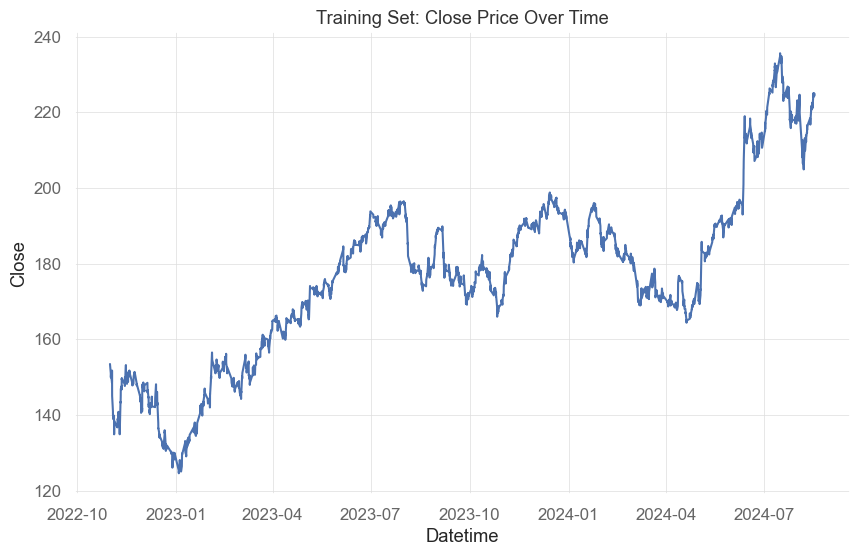

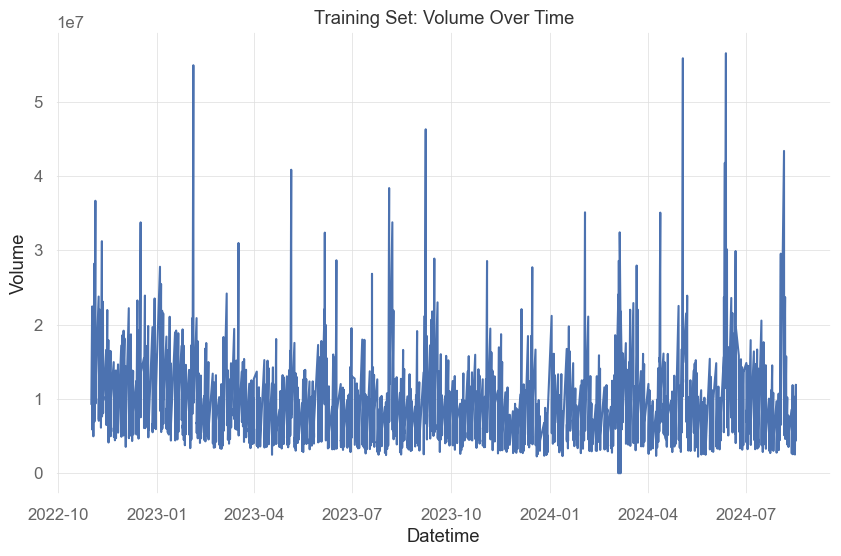

In [19]:
# Time Series Analysis
def plot_time_series(df, column, title):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Datetime'], df[column])
    plt.title(title)
    plt.xlabel('Datetime')
    plt.ylabel(column)
    plt.show()

plot_time_series(eda_train, 'Close', 'Training Set: Close Price Over Time')
plot_time_series(eda_train, 'Volume', 'Training Set: Volume Over Time')

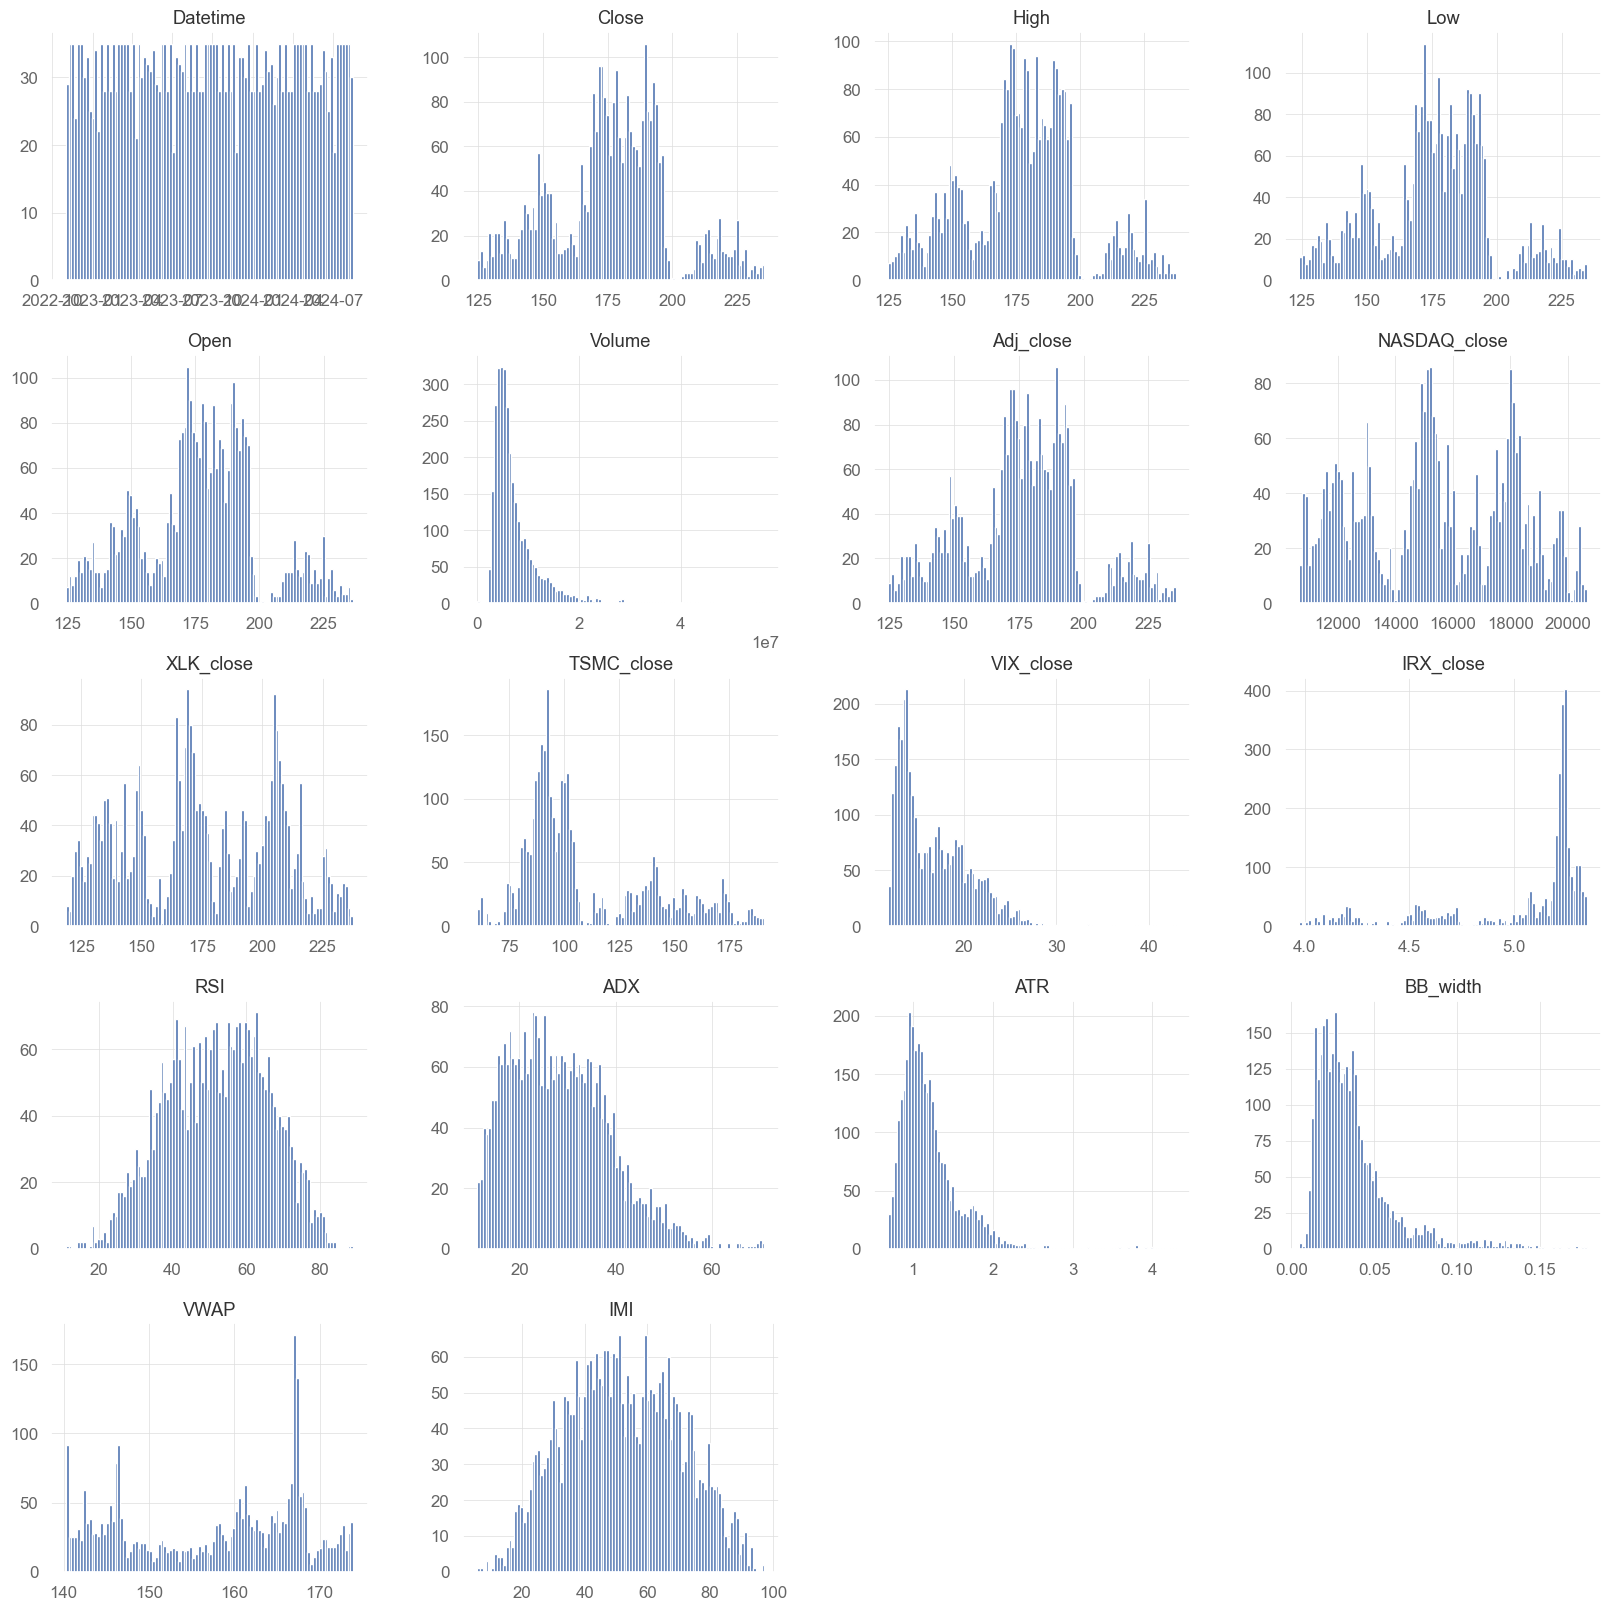

In [20]:
# Distribution of Key Features
def plot_histograms(df):
    df.hist(bins=100, figsize=(20, 20))
    plt.show()

plot_histograms(eda_train)

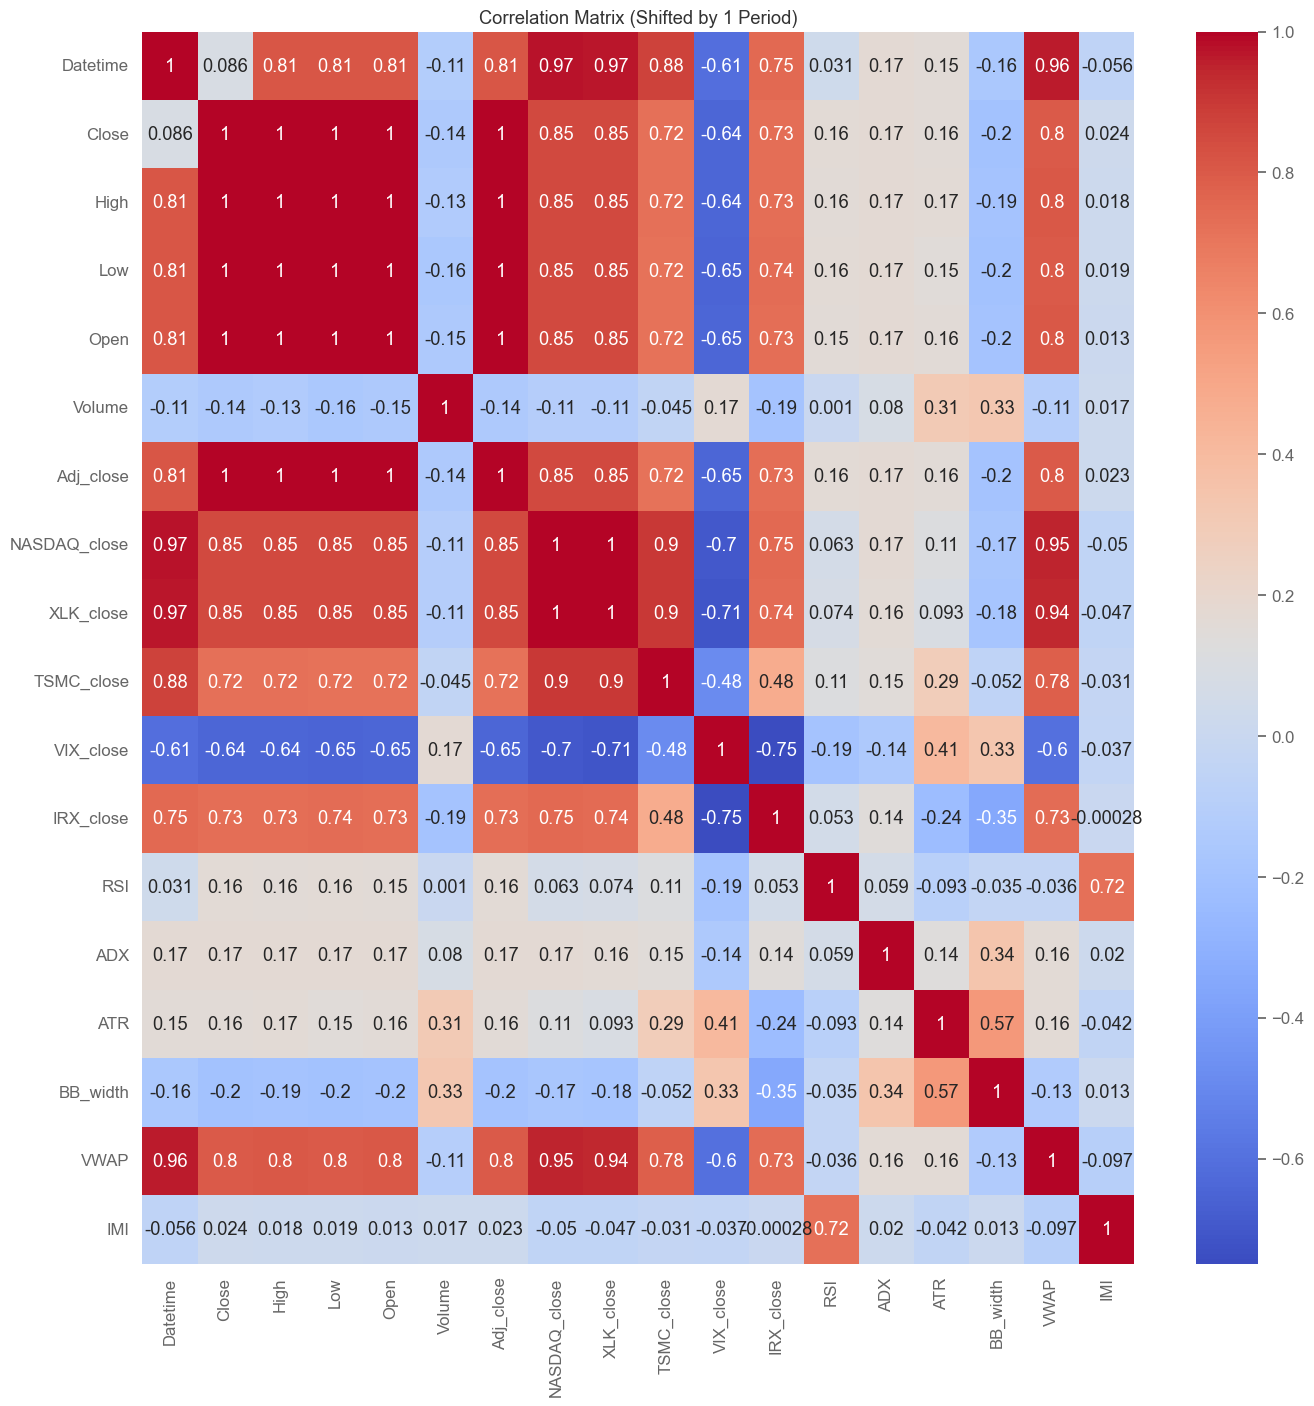

In [21]:
# Correlation Matrix and Heatmap (Shifted Data for Time-Lagged Comparison)
def correlation_analysis_shifted(df, target_column='Close', shift_period=1):
    # Shift features by one time period to compare with next-period Close
    shifted_df = df.shift(shift_period)
    shifted_df[target_column] = df[target_column]

    corr_matrix = shifted_df.corr()

    # Plot heatmap
    plt.figure(figsize=(16,16))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix (Shifted by {shift_period} Period)')
    plt.show()

    return corr_matrix

shifted_corr_matrix = correlation_analysis_shifted(eda_train)

In [22]:
# Variable Selection based on Correlation with Close Price
def select_important_features_shifted(corr_matrix, target_variable='Close', upper_threshold=0.95):
    correlations = corr_matrix[target_variable].abs()
    important_features = correlations[(correlations < upper_threshold)].index.tolist()
    
    # Remove the target variable itself
    if target_variable in important_features:
        important_features.remove(target_variable)
    
    # Remove 'Datetime'
    if 'Datetime' in important_features:
        important_features.remove('Datetime')
    
    print(f"Important features with correlation below {upper_threshold} for Next Period Close: {important_features}")
    return important_features

# Usage example
important_features_shifted = select_important_features_shifted(shifted_corr_matrix)

Important features with correlation below 0.95 for Next Period Close: ['Volume', 'NASDAQ_close', 'XLK_close', 'TSMC_close', 'VIX_close', 'IRX_close', 'RSI', 'ADX', 'ATR', 'BB_width', 'VWAP', 'IMI']


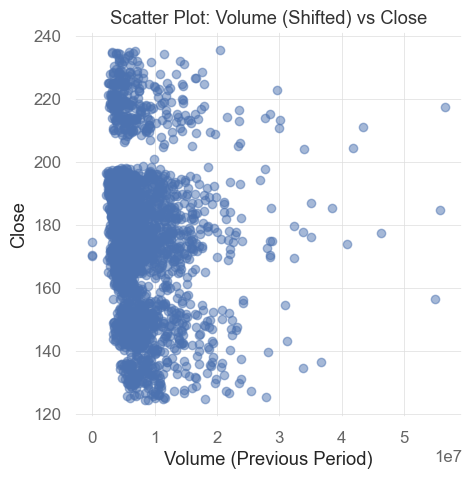

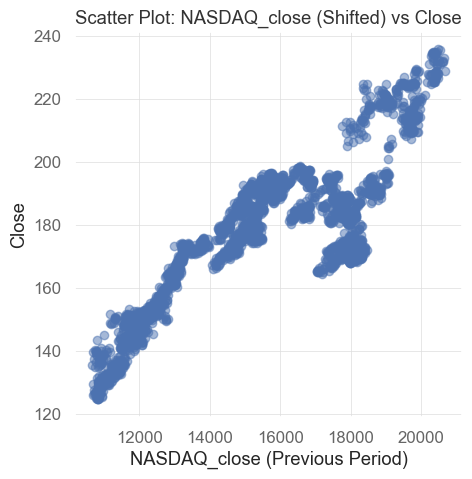

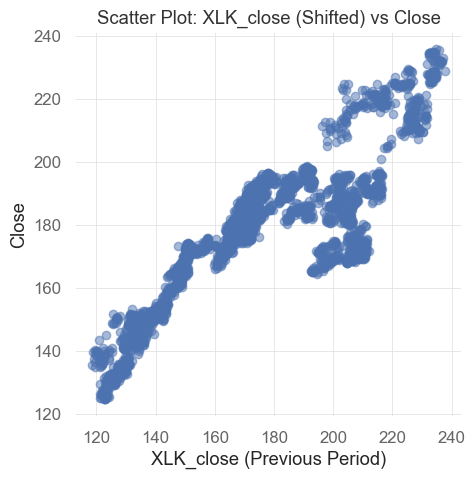

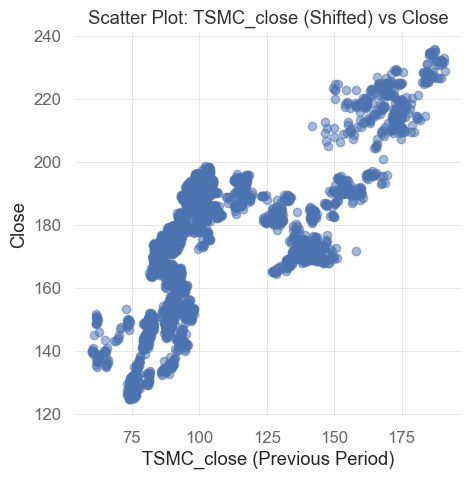

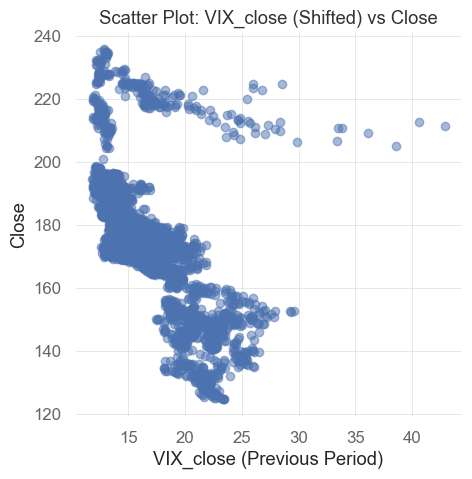

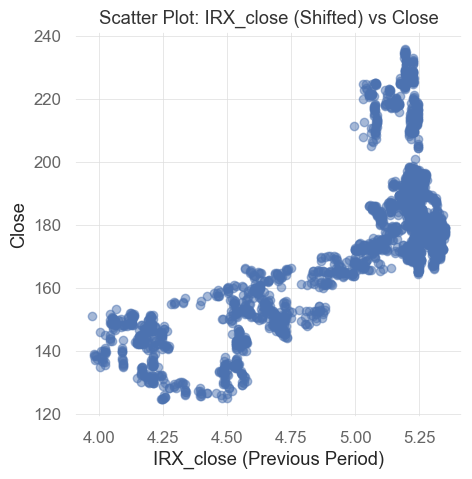

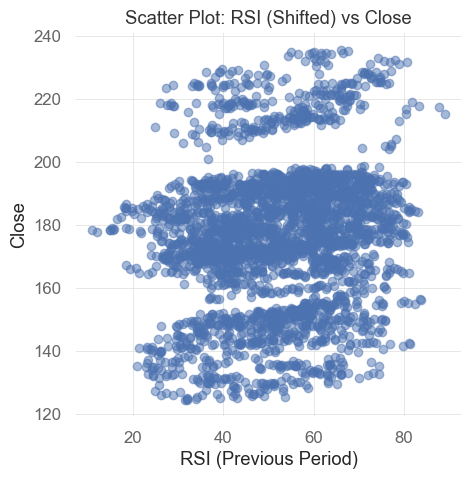

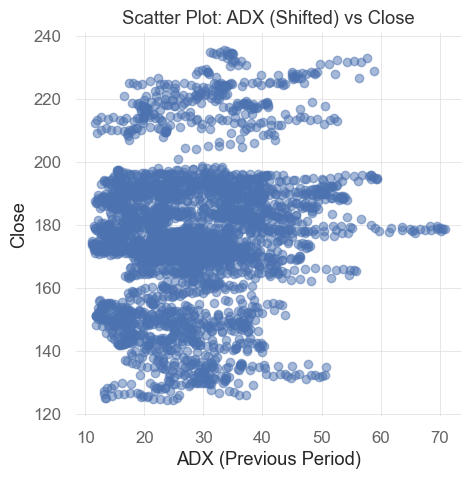

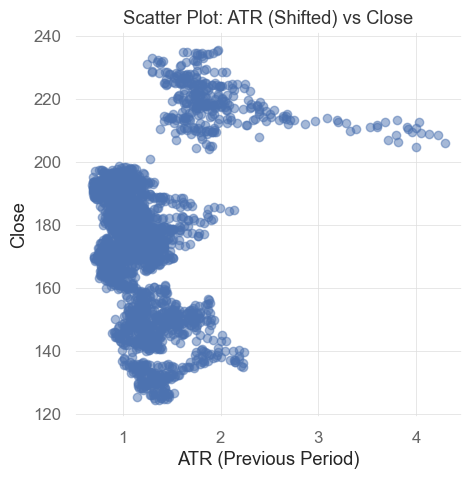

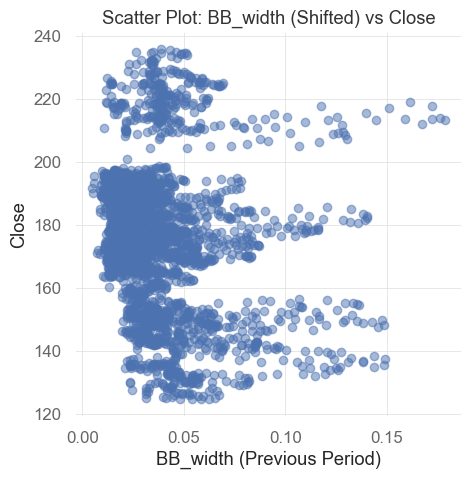

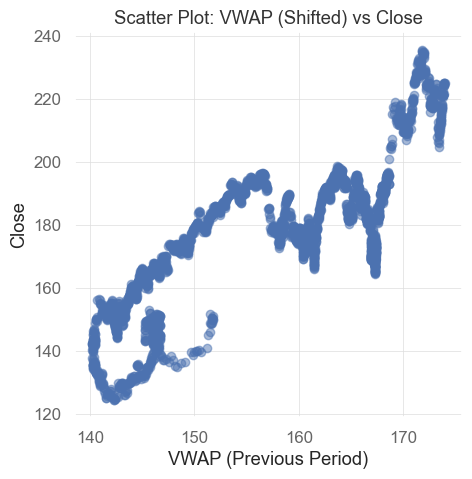

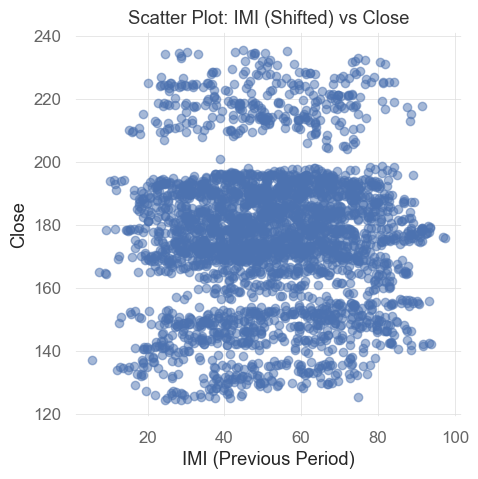

In [23]:
# Scatter Plot between Important Features and 'Close'
def scatter_plot_shifted(df, feature, target, shift_period=1):
    shifted_df = df.shift(shift_period)
    plt.figure(figsize=(5, 5))
    plt.scatter(shifted_df[feature], df[target], alpha=0.5)
    plt.title(f'Scatter Plot: {feature} (Shifted) vs {target}')
    plt.xlabel(f'{feature} (Previous Period)')
    plt.ylabel(target)
    plt.show()

for feature in important_features_shifted:
    scatter_plot_shifted(eda_train, feature, 'Close')


Autocorrelation and Partial Autocorrelation Analysis for Close:


<Figure size 1000x600 with 0 Axes>

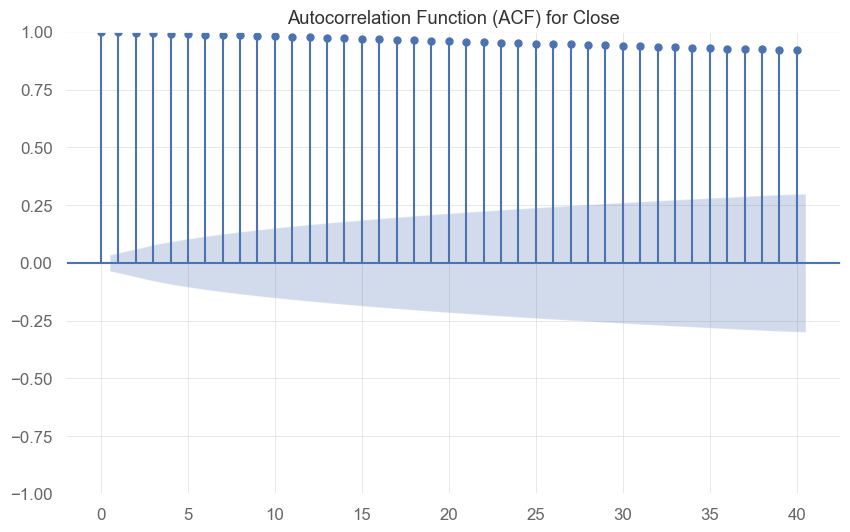

<Figure size 1000x600 with 0 Axes>

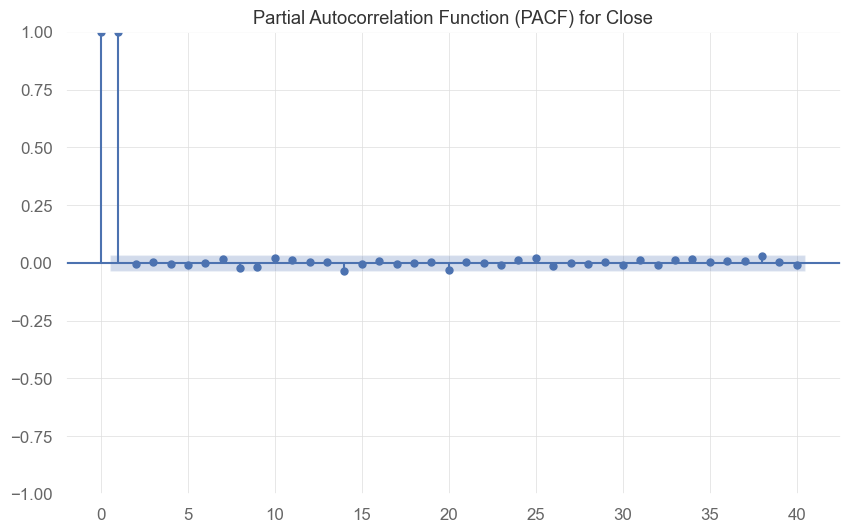

In [24]:
# Autocorrelation and Partial Autocorrelation Analysis (Hourly Data)
def autocorrelation_analysis(df, column='Close', lags=40):
    plt.figure(figsize=(10, 6))
    plot_acf(df[column], lags=lags)
    plt.title(f'Autocorrelation Function (ACF) for {column}')
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pacf(df[column], lags=lags)
    plt.title(f'Partial Autocorrelation Function (PACF) for {column}')
    plt.show()

print("\nAutocorrelation and Partial Autocorrelation Analysis for Close:")
autocorrelation_analysis(eda_train, column='Close', lags=40)


Seasonality Decomposition for Close Price:


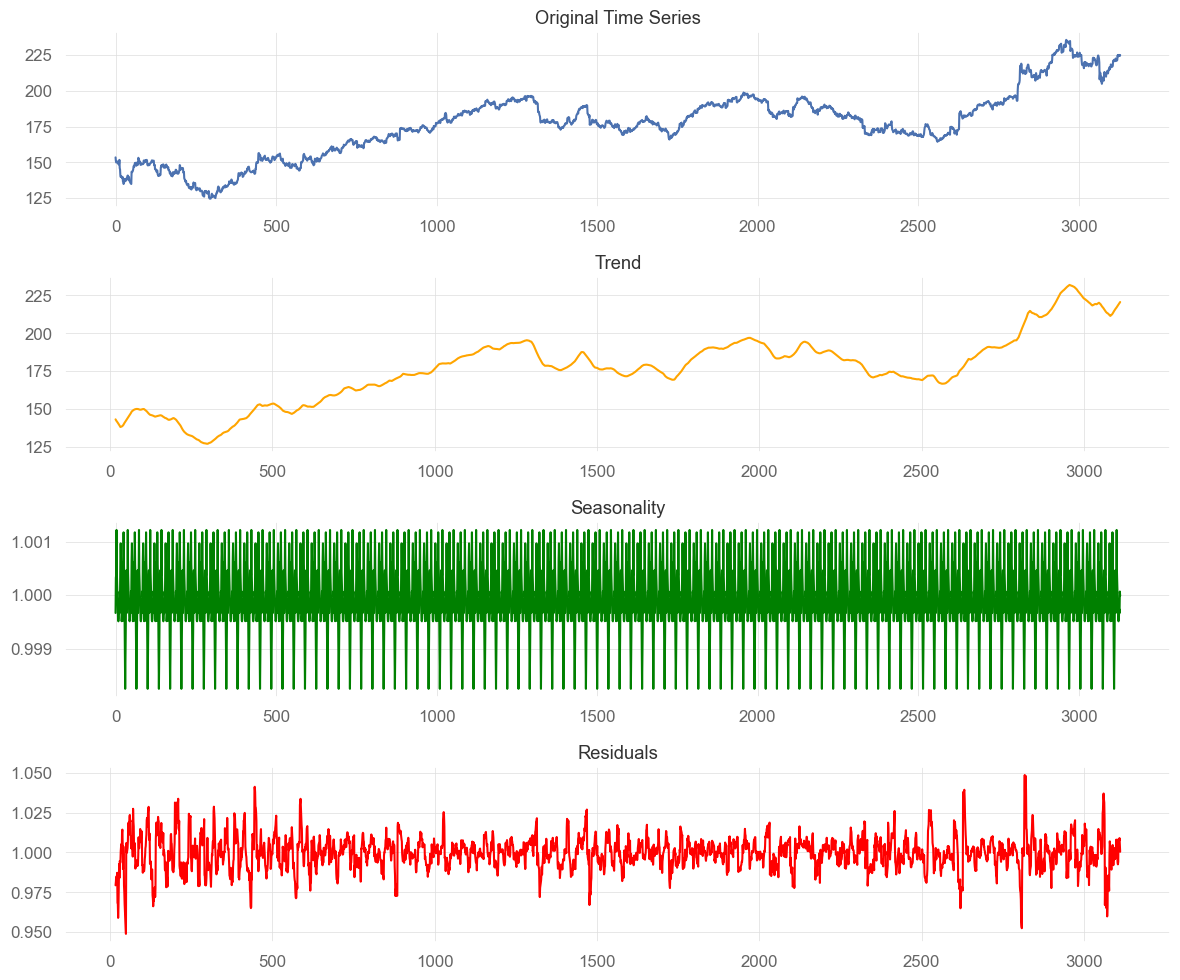

In [25]:
# Seasonality Decomposition
# Decomposing the Close price into trend, seasonality, and residuals
def seasonality_decomposition(df, column='Close', model='multiplicative', freq=35):
    result = seasonal_decompose(df[column], model=model, period=freq)

    # Plot the decomposition
    plt.figure(figsize=(12, 10))

    plt.subplot(411)
    plt.plot(df[column], label='Original')
    plt.title('Original Time Series')
    
    plt.subplot(412)
    plt.plot(result.trend, label='Trend', color='orange')
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonality', color='green')
    plt.title('Seasonality')

    plt.subplot(414)
    plt.plot(result.resid, label='Residuals', color='red')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()

    return result

print("\nSeasonality Decomposition for Close Price:")
decomposition_result = seasonality_decomposition(eda_train, column='Close', model='multiplicative', freq=35)

In [26]:
results = data

## Part 3: Data Modelling

### Basic Model

#### Data Cleaning

In [27]:
# Split the Data into Training and Testing Sets
arima_train_size = int(len(data) * 0.9)
arima_train = data['Close'][:arima_train_size].copy()
arima_test = data['Close'][arima_train_size:].copy()

print(f"ARIMA Training set shape: {arima_train.shape}")
print(f"ARIMA Testing set shape: {arima_test.shape}")

ARIMA Training set shape: (3130,)
ARIMA Testing set shape: (348,)


#### ARIMA Model

In [28]:
# Test the stationarity of series
def test_stationarity(timeseries):
    adf_test = adfuller(timeseries)
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'{key}: {value}')

In [29]:
# Test the stationarity of train dataset
test_stationarity(arima_train)

ADF Statistic: -0.7059164016837125
p-value: 0.8452110987305155
Critical Values:
1%: -3.4324463116051227
5%: -2.8624662204644187
10%: -2.567263049245277


In [30]:
# Perform first-order differencing on train dataset
arima_train_diff_1 = arima_train.diff(1).dropna()

# Test the stationarity
test_stationarity(arima_train_diff_1)

ADF Statistic: -20.416335945046143
p-value: 0.0
Critical Values:
1%: -3.4324463116051227
5%: -2.8624662204644187
10%: -2.567263049245277


In [31]:
# Use auto_arima to choose the optimal model
auto_arima_model = auto_arima(arima_train,d=1,seasonal=True,stepwise=True,trace=True)
print(f"Optimal ARIMA order: {auto_arima_model.order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9177.674, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9179.637, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9179.635, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9177.159, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9181.372, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.044 seconds
Optimal ARIMA order: (0, 1, 0)


In [32]:
# Use the optimal order from auto_arima
optimal_order = auto_arima_model.order

# Fit the ARIMA model using the optimal parameters
arima_model_1 = ARIMA(arima_train, order=optimal_order)
arima_fitted_1 = arima_model_1.fit()

In [33]:
# Make Predictions on the Test Set
arima_predictions_1 = arima_fitted_1.predict(start=len(arima_train), end=len(data) - 1)

# Add the ARIMA Predictions Back to the 'results' DataFrame
# Reset index of predictions and get corresponding 'Datetime's
arima_predictions_1 = arima_predictions_1.reset_index(drop=True)
arima_prediction_dates = data['Datetime'][arima_train_size:].reset_index(drop=True)

# Create a DataFrame with 'Datetime' and 'ARIMA_Pred'
arima_pred_df = pd.DataFrame({
    'Datetime': arima_prediction_dates,
    'ARIMA_Pred': arima_predictions_1.values
})

# Merge the predictions into the 'results' DataFrame on 'Datetime'
results_1 = results.merge(arima_pred_df, on='Datetime', how='left')

# Drop NaN rows
results_1 = results_1.dropna(subset=['ARIMA_Pred'])

# Display the updated DataFrame with actual 'Close' prices and predicted 'ARIMA_Pred'
results_1

Datetime       Close        High         Low        Open  \
3130 2024-08-16 15:30:00  226.339996  226.445602  224.910004  224.910004   
3131 2024-08-16 16:30:00  226.550003  226.827103  226.309998  226.350006   
3132 2024-08-16 17:30:00  225.990005  226.669998  225.630005  226.550003   
3133 2024-08-16 18:30:00  225.960007  226.210007  225.763596  225.985001   
3134 2024-08-16 19:30:00  226.100006  226.139999  225.539993  225.960495   
...                  ...         ...         ...         ...         ...   
3473 2024-10-25 15:30:00  232.710007  232.731995  231.759995  232.229996   
3474 2024-10-25 16:30:00  231.857498  232.940002  231.529999  232.735001   
3475 2024-10-25 17:30:00  231.839996  231.971497  231.070007  231.830002   
3476 2024-10-25 18:30:00  231.619995  232.199997  231.369995  231.846893   
3477 2024-10-25 19:30:00  231.399994  231.800003  231.110001  231.649994   

         Volume   Adj_close  NASDAQ_close   XLK_close  TSMC_close  VIX_close  \
3130  5068731.0  226.339996  19521.140625  221.300003  173.910004  14.760000   
3131  4500362.0  226.550003  19543.373047  221.559998  173.985001  14.690000   
3132  3023962.0  225.990005  19518.472656  221.460007  174.000000  14.870000   
3133  2364036.0  225.960007  19508.003906  221.250000  174.529999  14.670000   
3134  3252354.0  226.100006  19508.808594  221.389999  174.550003  14.790000   
...         ...         ...           ...         ...         ...        ...   
3473  3211126.0  232.710007  20511.517578  232.460007  204.619995  18.920000   
3474  2367087.0  231.857498  20425.835938  231.229996  204.050003  18.870001   
3475  2818009.0  231.839996  20392.525391  230.889893  204.190002  20.080000   
3476  2642893.0  231.619995  20370.580078  230.660004  203.809998  19.530001   
3477  3572932.0  231.399994  20352.699219  230.330002  203.389999  20.200001   

      IRX_close        RSI        ADX       ATR  BB_width        VWAP  \
3130      5.075  70.485156  42.949962  1.413452  0.032937  173.962336   
3131      5.073  71.087835  43.464593  1.349427  0.034493  173.972432   
3132      5.075  67.150247  43.045111  1.327325  0.033963  173.979153   
3133      5.075  66.936353  42.655591  1.264402  0.033579  173.984394   
3134      5.075  67.457322  41.990004  1.216946  0.032559  173.991596   
...         ...        ...        ...       ...       ...         ...   
3473      4.500  54.273514  26.793596  1.345378  0.038488  177.465532   
3474      4.500  49.358543  25.247241  1.349994  0.035628  177.470680   
3475      4.508  49.259916  24.159540  1.317958  0.031453  177.476754   
3476      4.510  47.962551  22.939260  1.283104  0.025665  177.482460   
3477      4.510  46.639705  22.016857  1.240739  0.021164  177.490130   

            IMI  ARIMA_Pred  
3130  70.542717  224.910004  
3131  72.797330  224.910004  
3132  65.825520  224.910004  
3133  69.076777  224.910004  
3134  67.589745  224.910004  
...         ...         ...  
3473  78.091265  224.910004  
3474  69.424765  224.910004  
3475  82.441966  224.910004  
3476  76.783967  224.910004  
3477  69.325480  224.910004  

[348 rows x 19 columns]

In [34]:
# Initialize the model_evaluation DataFrame
model_evaluation = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'MAPE(%)', 'Training Time(s)'])

# Record training time for ARIMA with d=1
start_time_1 = time.time()
arima_model_1 = ARIMA(arima_train, order=optimal_order)
arima_fitted_1 = arima_model_1.fit()
training_time_1 = time.time() - start_time_1

# Evaluate the Model Performance
mse_arima_1 = mean_squared_error(results_1['Close'], results_1['ARIMA_Pred'])
rmse_arima_1 = np.sqrt(mse_arima_1)
mae_arima_1 = mean_absolute_error(results_1['Close'], results_1['ARIMA_Pred'])
mape_arima_1 = mean_absolute_percentage_error(results_1['Close'], results_1['ARIMA_Pred'])

# Prepare the evaluation metrics for ARIMA_1D
arima_metrics_1 = {
    'Model': 'ARIMA_1D',
    'MSE': mse_arima_1,
    'RMSE': rmse_arima_1,
    'MAE': mae_arima_1,
    'MAPE(%)': mape_arima_1 * 100,
    'Training Time(s)': training_time_1
}

# Append the ARIMA_1D metrics to the model_evaluation DataFrame
model_evaluation = pd.concat([model_evaluation, pd.DataFrame([arima_metrics_1])], ignore_index=True)

# Print the error metrics
print(f'ARIMA_1D MSE: {mse_arima_1:.2f}')
print(f'ARIMA_1D RMSE: {rmse_arima_1:.2f}')
print(f'ARIMA_1D MAE: {mae_arima_1:.2f}')
print(f'ARIMA_1D MAPE: {mape_arima_1 * 100:.2f}%')

ARIMA_1D MSE: 24.41
ARIMA_1D RMSE: 4.94
ARIMA_1D MAE: 3.97
ARIMA_1D MAPE: 1.74%


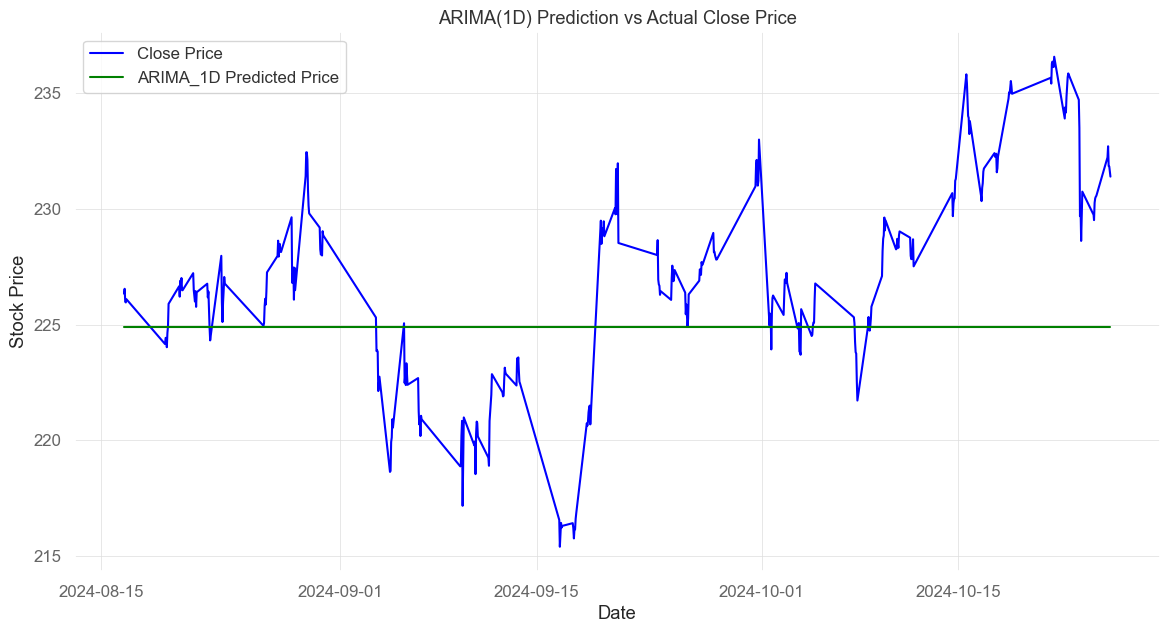

In [35]:
# Create a line graph for 'Close', 'ARIMA_Pred' from results_1
plt.figure(figsize=(14, 7))

# Plot 'Close' prices (common across all datasets)
plt.plot(results_1['Datetime'], results_1['Close'], label='Close Price', color='blue')

# Plot 'ARIMA_Pred' predictions from results_1
plt.plot(results_1['Datetime'], results_1['ARIMA_Pred'], label='ARIMA_1D Predicted Price', color='green')

# Add title, labels, and legend
plt.title('ARIMA(1D) Prediction vs Actual Close Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Show the graph
plt.show()

In [36]:
# The function of the model with d=1 doesn't have good performance, considering perform second-order differencing
# Perform second-order differencing on train dataset
arima_train_diff_2 = arima_train.diff(2).dropna()

# Test the stationarity
test_stationarity(arima_train_diff_2)

ADF Statistic: -10.109006494462621
p-value: 1.0119424641480536e-17
Critical Values:
1%: -3.4324625650777096
5%: -2.862473399244694
10%: -2.567266871114916


In [37]:
# Use d=2 to build a new ARIMA model
auto_arima_model_2 = auto_arima(arima_train,d=2,seasonal=True,stepwise=True,trace=True)
print(f"Optimal ARIMA order: {auto_arima_model_2.order}")

# Use the optimal order from auto_arima
optimal_order_2 = auto_arima_model_2.order

# Fit the ARIMA model using the optimal parameters
arima_model_2 = ARIMA(arima_train, order=optimal_order_2)
arima_fitted_2 = arima_model_2.fit()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.77 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11349.873, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=10489.221, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=10092.447, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=9867.479, Time=0.12 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=9736.401, Time=0.13 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=9684.184, Time=0.18 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.84 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.32 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=9686.181, Time=0.36 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 6.278 seconds
Optimal ARIMA order: (5, 2, 0)


In [38]:
# Make Predictions on the Test Set
arima_predictions_2 = arima_fitted_2.predict(start=len(arima_train), end=len(data) - 1)

# Add the ARIMA Predictions Back to the 'results' DataFrame
# Reset index of predictions and get corresponding 'Datetime's
arima_predictions_2 = arima_predictions_2.reset_index(drop=True)
arima_prediction_dates = data['Datetime'][arima_train_size:].reset_index(drop=True)

# Create a DataFrame with 'Datetime' and 'ARIMA_Pred'
arima_pred_df = pd.DataFrame({
    'Datetime': arima_prediction_dates,
    'ARIMA_Pred': arima_predictions_2.values
})

# Merge the predictions into the 'results' DataFrame on 'Datetime'
results_2 = results.merge(arima_pred_df, on='Datetime', how='left')

# Drop NaN rows
results_2 = results_2.dropna(subset=['ARIMA_Pred'])

# Display the updated DataFrame with actual 'Close' prices and predicted 'ARIMA_Pred'
results_2

Datetime       Close        High         Low        Open  \
3130 2024-08-16 15:30:00  226.339996  226.445602  224.910004  224.910004   
3131 2024-08-16 16:30:00  226.550003  226.827103  226.309998  226.350006   
3132 2024-08-16 17:30:00  225.990005  226.669998  225.630005  226.550003   
3133 2024-08-16 18:30:00  225.960007  226.210007  225.763596  225.985001   
3134 2024-08-16 19:30:00  226.100006  226.139999  225.539993  225.960495   
...                  ...         ...         ...         ...         ...   
3473 2024-10-25 15:30:00  232.710007  232.731995  231.759995  232.229996   
3474 2024-10-25 16:30:00  231.857498  232.940002  231.529999  232.735001   
3475 2024-10-25 17:30:00  231.839996  231.971497  231.070007  231.830002   
3476 2024-10-25 18:30:00  231.619995  232.199997  231.369995  231.846893   
3477 2024-10-25 19:30:00  231.399994  231.800003  231.110001  231.649994   

         Volume   Adj_close  NASDAQ_close   XLK_close  TSMC_close  VIX_close  \
3130  5068731.0  226.339996  19521.140625  221.300003  173.910004  14.760000   
3131  4500362.0  226.550003  19543.373047  221.559998  173.985001  14.690000   
3132  3023962.0  225.990005  19518.472656  221.460007  174.000000  14.870000   
3133  2364036.0  225.960007  19508.003906  221.250000  174.529999  14.670000   
3134  3252354.0  226.100006  19508.808594  221.389999  174.550003  14.790000   
...         ...         ...           ...         ...         ...        ...   
3473  3211126.0  232.710007  20511.517578  232.460007  204.619995  18.920000   
3474  2367087.0  231.857498  20425.835938  231.229996  204.050003  18.870001   
3475  2818009.0  231.839996  20392.525391  230.889893  204.190002  20.080000   
3476  2642893.0  231.619995  20370.580078  230.660004  203.809998  19.530001   
3477  3572932.0  231.399994  20352.699219  230.330002  203.389999  20.200001   

      IRX_close        RSI        ADX       ATR  BB_width        VWAP  \
3130      5.075  70.485156  42.949962  1.413452  0.032937  173.962336   
3131      5.073  71.087835  43.464593  1.349427  0.034493  173.972432   
3132      5.075  67.150247  43.045111  1.327325  0.033963  173.979153   
3133      5.075  66.936353  42.655591  1.264402  0.033579  173.984394   
3134      5.075  67.457322  41.990004  1.216946  0.032559  173.991596   
...         ...        ...        ...       ...       ...         ...   
3473      4.500  54.273514  26.793596  1.345378  0.038488  177.465532   
3474      4.500  49.358543  25.247241  1.349994  0.035628  177.470680   
3475      4.508  49.259916  24.159540  1.317958  0.031453  177.476754   
3476      4.510  47.962551  22.939260  1.283104  0.025665  177.482460   
3477      4.510  46.639705  22.016857  1.240739  0.021164  177.490130   

            IMI  ARIMA_Pred  
3130  70.542717  224.917599  
3131  72.797330  224.939404  
3132  65.825520  224.913702  
3133  69.076777  224.910189  
3134  67.589745  224.962246  
...         ...         ...  
3473  78.091265  236.063265  
3474  69.424765  236.095948  
3475  82.441966  236.128631  
3476  76.783967  236.161314  
3477  69.325480  236.193997  

[348 rows x 19 columns]

In [39]:
# Record training time for ARIMA with d=2
start_time_2 = time.time()
arima_model_2 = ARIMA(arima_train, order=optimal_order_2)
arima_fitted_2 = arima_model_2.fit()
training_time_2 = time.time() - start_time_2

# Evaluate the Model Performance
mse_arima_2 = mean_squared_error(results_2['Close'], results_2['ARIMA_Pred'])
rmse_arima_2 = np.sqrt(mse_arima_2)
mae_arima_2 = mean_absolute_error(results_2['Close'], results_2['ARIMA_Pred'])
mape_arima_2 = mean_absolute_percentage_error(results_2['Close'], results_2['ARIMA_Pred'])

# Prepare the evaluation metrics for ARIMA_2D
arima_metrics_2 = {
    'Model': 'ARIMA_2D',
    'MSE': mse_arima_2,
    'RMSE': rmse_arima_2,
    'MAE': mae_arima_2,
    'MAPE(%)': mape_arima_2 * 100,
    'Training Time(s)': training_time_2
}

# Append the ARIMA_2D metrics to the model_evaluation DataFrame
model_evaluation = pd.concat([model_evaluation, pd.DataFrame([arima_metrics_2])], ignore_index=True)

# Print the error metrics
print(f'ARIMA_2D MSE: {mse_arima_2:.2f}')
print(f'ARIMA_2D RMSE: {rmse_arima_2:.2f}')
print(f'ARIMA_2D MAE: {mae_arima_2:.2f}')
print(f'ARIMA_2D MAPE: {mape_arima_2 * 100:.2f}%')

ARIMA_2D MSE: 30.87
ARIMA_2D RMSE: 5.56
ARIMA_2D MAE: 4.43
ARIMA_2D MAPE: 1.98%


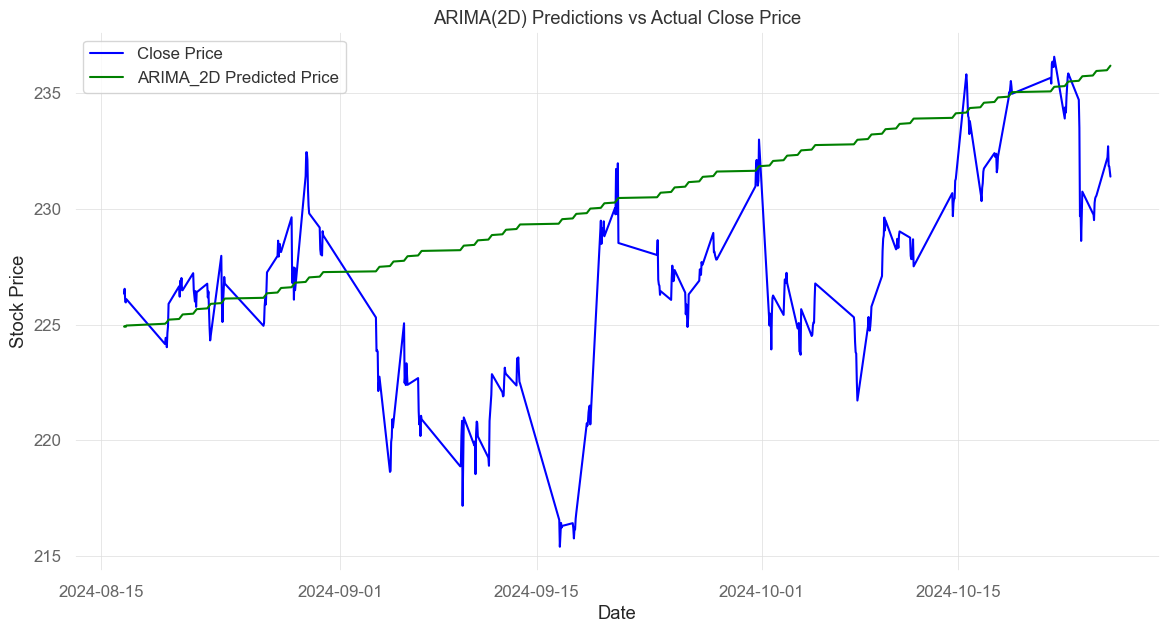

In [40]:
# Create a line graph for 'Close', 'ARIMA_Pred' from results_2
plt.figure(figsize=(14, 7))

# Plot 'Close' prices (common across all datasets)
plt.plot(results_2['Datetime'], results_2['Close'], label='Close Price', color='blue')

# Plot 'ARIMA_Pred' predictions from results_2
plt.plot(results_2['Datetime'], results_2['ARIMA_Pred'], label='ARIMA_2D Predicted Price', color='green')

# Add title, labels, and legend
plt.title('ARIMA(2D) Predictions vs Actual Close Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Show the graph
plt.show()

In [41]:
# Use the results of arima_model_2
results = results_2

### Machine Learning Model

#### Data Cleaning

In [42]:
# Create a separate copy for LSTM processing to avoid modifying the original data
lstm_data = data.copy()

# Drop NaN values resulting from returns computation
lstm_data = lstm_data.dropna()

# Extract datetime features
lstm_data['Datetime'] = pd.to_datetime(lstm_data['Datetime'])
lstm_data['Hour'] = lstm_data['Datetime'].dt.hour
lstm_data['Minute'] = lstm_data['Datetime'].dt.minute
lstm_data['DayOfWeek'] = lstm_data['Datetime'].dt.dayofweek

# Define NYSE calendar using pandas_market_calendars
nyse = mcal.get_calendar('NYSE')

# Get the date range from the data
start_date = lstm_data['Datetime'].min().strftime('%Y-%m-%d')
end_date = lstm_data['Datetime'].max().strftime('%Y-%m-%d')

# Get the NYSE market schedule for the date range of the DataFrame
schedule = nyse.schedule(pd.Timestamp(start_date), pd.Timestamp(end_date))

In [43]:
# Function to determine if the market is open and retrieve trading hours
def get_trading_hours(date):
    market_date = pd.Timestamp(date).normalize()
    
    # Check if the market is open on this date
    if market_date in schedule.index:
        open_time = schedule.at[market_date, 'market_open']
        close_time = schedule.at[market_date, 'market_close']
        
        # Convert times to hours in float format (e.g., 9:30 AM -> 9.5)
        open_hour = open_time.hour + open_time.minute / 60.0
        close_hour = close_time.hour + close_time.minute / 60.0
        
        return open_hour, close_hour
    else:
        # If market is closed (holiday or weekend), return None
        return None

# Function to encode time dynamically based on market hours
def encode_time(row):
    date = row['Datetime'].date()
    trading_hours = get_trading_hours(date)
    
    if trading_hours is None:
        # If market is closed, set cyclical features to default values (Zeros)
        row['Hour_sin'] = 0.0
        row['Hour_cos'] = 0.0
    else:
        open_time, close_time = trading_hours
        total_trading_hours = close_time - open_time
        
        # Calculate the fractional hour since market open
        hour_since_open = (row['Hour'] + row['Minute'] / 60.0) - open_time
        fraction_of_day = hour_since_open / total_trading_hours
        
        # Handle cases where fraction_of_day might be outside [0,1] due to data errors
        fraction_of_day = np.clip(fraction_of_day, 0, 1)
        
        # Apply cyclical encoding with sine and cosine
        row['Hour_sin'] = np.sin(2 * np.pi * fraction_of_day)
        row['Hour_cos'] = np.cos(2 * np.pi * fraction_of_day)
    return row

# Apply the dynamic time encoding to each row
lstm_data = lstm_data.apply(encode_time, axis=1)

# Function to encode day of the week cyclically
def dynamic_day_encoding(row):
    day_of_week = row['DayOfWeek']
    
    # Apply cyclic encoding for the day of the week (Monday to Friday = 0-4)
    if day_of_week < 5:
        row['DayOfWeek_sin'] = np.sin(2 * np.pi * day_of_week / 5)
        row['DayOfWeek_cos'] = np.cos(2 * np.pi * day_of_week / 5)
    else:
        # For weekends, set cyclical features to default values (e.g., zeros)
        row['DayOfWeek_sin'] = 0.0
        row['DayOfWeek_cos'] = 0.0
    return row

# Apply the dynamic day encoding to each row
lstm_data = lstm_data.apply(dynamic_day_encoding, axis=1)

# Drop any remaining NaN values to ensure clean data
lstm_data = lstm_data.dropna()

In [44]:
# Remove any unwanted columns from lstm_data
columns_to_exclude = ['Adj Close', 'High', 'Low', 'Open', 'Volume']
lstm_data = lstm_data.drop(columns=columns_to_exclude, errors='ignore')

# Define the list of numeric columns for the LSTM model
additional_columns = ['Close', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']
lstm_numeric_columns = important_features_shifted + additional_columns

# Exclude columns in `columns_to_exclude` from `lstm_numeric_columns`
lstm_numeric_columns = [col for col in lstm_numeric_columns if col not in columns_to_exclude]

# Ensure 'Datetime' is included in the columns for lstm_data
lstm_columns_to_use = ['Datetime'] + lstm_numeric_columns

# Filter lstm_data to keep only the specified columns
lstm_data = lstm_data[lstm_columns_to_use].copy()

# Split data into training (90%) and testing (10%) sets
train_size = int(len(lstm_data) * 0.9)
lstm_train = lstm_data.iloc[:train_size].copy()
lstm_test = lstm_data.iloc[train_size:].copy()

# Further split lstm_train into training and validation sets (latest 10% for validation)
validation_size = int(len(lstm_train) * 0.1)
lstm_train_new = lstm_train.iloc[:-validation_size].copy()
lstm_val = lstm_train.iloc[-validation_size:].copy()

# Print the resulting list to verify
print("LSTM Numeric Columns:", lstm_numeric_columns)
print("")

# Print shapes to verify the split
print(f"LSTM Training set shape: {lstm_train_new.shape}")
print(f"LSTM Validation set shape: {lstm_val.shape}")
print(f"LSTM Testing set shape: {lstm_test.shape}")

LSTM Numeric Columns: ['NASDAQ_close', 'XLK_close', 'TSMC_close', 'VIX_close', 'IRX_close', 'RSI', 'ADX', 'ATR', 'BB_width', 'VWAP', 'IMI', 'Close', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']

LSTM Training set shape: (2817, 17)
LSTM Validation set shape: (313, 17)
LSTM Testing set shape: (348, 17)


In [45]:
# Initialize scalers
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

# Fit scalers on lstm_train_new
feature_scaler.fit(lstm_train_new[lstm_numeric_columns])
target_scaler.fit(lstm_train_new[['Close']])

# Transform features and target in lstm_train_new
lstm_train_scaled = lstm_train_new.copy()
lstm_train_scaled.loc[:, lstm_numeric_columns] = feature_scaler.transform(lstm_train_new[lstm_numeric_columns])
lstm_train_scaled.loc[:, 'Close'] = target_scaler.transform(lstm_train_new[['Close']])

# Transform features and target in validation data
lstm_val_scaled = lstm_val.copy()
lstm_val_scaled.loc[:, lstm_numeric_columns] = feature_scaler.transform(lstm_val[lstm_numeric_columns])
lstm_val_scaled.loc[:, 'Close'] = target_scaler.transform(lstm_val[['Close']])

#### LSTM Model

In [46]:
# Create LSTM Dataset Function
def create_lstm_dataset(df, look_back):
    X, y, datetimes = [], [], []
    for i in range(len(df) - look_back):
        X.append(df[lstm_numeric_columns].iloc[i:i + look_back].values)
        y.append(df['Close'].iloc[i + look_back])
        datetimes.append(df['Datetime'].iloc[i + look_back])
    return np.array(X), np.array(y), datetimes

In [47]:
# Hyperparameter Tuning
def hyperparameter_tuning():
    # Calculate maximum allowable lstm_look_back based on validation data
    min_dataset_length = min(len(lstm_train_scaled), len(lstm_val_scaled))
    max_look_back = min(min_dataset_length - 20, 160)  # Ensure it's at most 160
    max_look_back = max(20, max_look_back)  # Ensure it's at least 20

    class MyHyperModel(kt.HyperModel):
        def build(self, hp):
            # Define hyperparameters
            lstm_units = hp.Int('lstm_units', min_value=32, max_value=256, step=32)
            lstm_units_2 = hp.Int('lstm_units_2', min_value=32, max_value=256, step=32)
            dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)
            lstm_look_back = hp.Int('lstm_look_back', min_value=20, max_value=max_look_back, step=20)
            l2_reg = hp.Float('l2_reg', 1e-5, 1e-3, sampling='log')
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
            batch_size = hp.Int('batch_size', min_value=16, max_value=128, step=16)

            # Build the LSTM model with Attention
            inputs = Input(shape=(lstm_look_back, len(lstm_numeric_columns)))
            x = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(l2_reg))(inputs)
            x = Dropout(dropout_rate)(x)
            x = LSTM(units=lstm_units_2, return_sequences=True, kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout_rate)(x)

            # Attention mechanism
            attention_output = Attention()([x, x])
            x = Concatenate()([x, attention_output])
            x = Flatten()(x)

            x = BatchNormalization()(x)
            outputs = Dense(1, activation='linear', kernel_regularizer=l2(l2_reg))(x)

            model = Model(inputs=inputs, outputs=outputs)

            # Cosine annealing learning rate schedule
            cosine_lr = CosineDecayRestarts(
                initial_learning_rate=learning_rate,
                first_decay_steps=100,
                t_mul=1.0,
                m_mul=1.0,
                alpha=0.0
            )
            optimizer = Adam(learning_rate=cosine_lr)

            # Compile the model with Huber loss and additional metrics
            model.compile(optimizer=optimizer, loss='huber_loss', metrics=['mae', 'mape'])

            return model

        def fit(self, hp, model, *args, **kwargs):
            lstm_look_back = hp.get('lstm_look_back')
            batch_size = hp.get('batch_size')
            lstm_X_train, lstm_y_train, _ = create_lstm_dataset(lstm_train_scaled, lstm_look_back)
            lstm_X_val, lstm_y_val, _ = create_lstm_dataset(lstm_val_scaled, lstm_look_back)

            # Check if datasets are large enough
            if len(lstm_X_train) == 0 or len(lstm_X_val) == 0:
                # Skip this trial
                raise kt.exceptions.FatalValueError("Insufficient data for the given look_back.")

            try:
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
                history = model.fit(
                    lstm_X_train,
                    lstm_y_train,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(lstm_X_val, lstm_y_val),
                    callbacks=[early_stopping],
                    verbose=0
                )
                return history
            except Exception as e:
                # Raise an exception to skip the trial
                raise kt.exceptions.FatalValueError(f"Exception during model training: {str(e)}")

    # Initialize the tuner
    tuner = kt.BayesianOptimization(
        MyHyperModel(),
        objective=kt.Objective('val_loss', direction='min'),
        max_trials=100,
        directory='lstm_tuning',
        project_name='stock_prediction_tuning',
        overwrite=True
    )

    return tuner

# Perform hyperparameter tuning
tuner = hyperparameter_tuning()
tuner.search()

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal hyperparameters are:
- lstm_units: {best_hps.get('lstm_units')}
- lstm_units_2: {best_hps.get('lstm_units_2')}
- dropout_rate: {best_hps.get('dropout_rate')}
- lstm_look_back: {best_hps.get('lstm_look_back')}
- l2_reg: {best_hps.get('l2_reg')}
- learning_rate: {best_hps.get('learning_rate')}
- batch_size: {best_hps.get('batch_size')}
""")

Trial 100 Complete [00h 01m 45s]
val_loss: 0.37179410457611084

Best val_loss So Far: 0.004739080090075731
Total elapsed time: 01h 40m 37s

The hyperparameter search is complete. The optimal hyperparameters are:
- lstm_units: 160
- lstm_units_2: 32
- dropout_rate: 0.1
- lstm_look_back: 20
- l2_reg: 0.0006241649562111259
- learning_rate: 0.003335287750552828
- batch_size: 16



In [48]:
# Build and Compile the Final LSTM Model
def build_lstm_model(input_shape, best_hps):
    lstm_units = best_hps.get('lstm_units')
    lstm_units_2 = best_hps.get('lstm_units_2')
    dropout_rate = best_hps.get('dropout_rate')
    l2_reg = best_hps.get('l2_reg')
    learning_rate = best_hps.get('learning_rate')

    inputs = Input(shape=input_shape)
    x = LSTM(units=lstm_units, return_sequences=True, kernel_regularizer=l2(l2_reg))(inputs)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units=lstm_units_2, return_sequences=True, kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)

    # Attention mechanism
    attention_output = Attention()([x, x])
    x = Concatenate()([x, attention_output])
    x = Flatten()(x)

    x = BatchNormalization()(x)
    outputs = Dense(1, activation='linear', kernel_regularizer=l2(l2_reg))(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Cosine annealing learning rate schedule
    cosine_lr = CosineDecayRestarts(
        initial_learning_rate=learning_rate,
        first_decay_steps=100,
        t_mul=1.0,
        m_mul=1.0,
        alpha=0.0
    )
    optimizer = Adam(learning_rate=cosine_lr)

    # Compile the model with Huber loss and additional metrics
    model.compile(optimizer=optimizer, loss='huber_loss', metrics=['mae', 'mape'])

    return model

In [49]:
# Learning Rate Logger Callback
class LearningRateLogger(Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        self.lrs.append(lr)

In [50]:
# Visualization Function
def visualize_training_metrics(history, lr_tracker, fold):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss and Validation Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{fold} - Loss and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Learning Rate
    plt.subplot(1, 2, 2)
    plt.plot(epochs, lr_tracker.lrs, label='Learning Rate', color='green')
    plt.title(f'{fold} - Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [51]:
# Walk-Forward Validation
def walk_forward_validation(data, n_test, lstm_look_back_best, best_hps):
    mse_scores, mae_scores, rmse_scores, mape_scores = [], [], [], []
    n_records = len(data)

    for i in range(0, n_records - n_test, n_test):
        train = data.iloc[:i + n_test].copy()
        test = data.iloc[i + n_test:i + n_test + n_test].copy()
        if len(test) < lstm_look_back_best:
            break

        # Scale the data
        feature_scaler = RobustScaler()
        target_scaler = RobustScaler()

        feature_scaler.fit(train[lstm_numeric_columns])
        target_scaler.fit(train[['Close']])

        train_scaled = train.copy()
        train_scaled.loc[:, lstm_numeric_columns] = feature_scaler.transform(train[lstm_numeric_columns])
        train_scaled.loc[:, 'Close'] = target_scaler.transform(train[['Close']])

        # Include the last 'lstm_look_back_best' rows from train in test
        test_combined = pd.concat([train.tail(lstm_look_back_best), test])
        test_scaled = test_combined.copy()
        test_scaled.loc[:, lstm_numeric_columns] = feature_scaler.transform(test_combined[lstm_numeric_columns])
        test_scaled.loc[:, 'Close'] = target_scaler.transform(test_combined[['Close']])

        # Create datasets
        lstm_X_train, lstm_y_train, _ = create_lstm_dataset(train_scaled, lstm_look_back_best)
        lstm_X_test, lstm_y_test, _ = create_lstm_dataset(test_scaled, lstm_look_back_best)

        # Check if datasets are large enough
        if len(lstm_X_train) == 0 or len(lstm_X_test) == 0:
            continue

        # Build and compile the model
        lstm_model = build_lstm_model((lstm_look_back_best, len(lstm_numeric_columns)), best_hps)

        # Track learning rate
        lr_tracker = LearningRateLogger()

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

        # Model checkpoint to save best model
        checkpoint_filepath = f'best_model_fold_{i}.h5'
        model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True)

        # Train the model
        history = lstm_model.fit(
            lstm_X_train,
            lstm_y_train,
            epochs=100,
            batch_size=best_hps.get('batch_size'),
            validation_split=0.1,
            callbacks=[early_stopping, lr_tracker, model_checkpoint],
            verbose=0
        )

        # Visualize Training Metrics
        visualize_training_metrics(history, lr_tracker, fold=f'Walk-Forward Step {i // n_test + 1}')

        # Load the best model
        lstm_model = load_model(checkpoint_filepath, custom_objects={'Attention': Attention})

        # Make predictions
        lstm_y_pred = lstm_model.predict(lstm_X_test)

        # Inverse-transform the predictions and actual values
        lstm_y_pred_inv = target_scaler.inverse_transform(lstm_y_pred)
        lstm_y_test_inv = target_scaler.inverse_transform(lstm_y_test.reshape(-1, 1))

        # Calculate evaluation metrics for each fold
        mse = mean_squared_error(lstm_y_test_inv, lstm_y_pred_inv)
        mae = mean_absolute_error(lstm_y_test_inv, lstm_y_pred_inv)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(lstm_y_test_inv, lstm_y_pred_inv)

        # Store metrics for this fold
        mse_scores.append(mse)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        mape_scores.append(mape)

    # Output the Average Metrics over all splits
    if len(mse_scores) > 0:
        print(f'Average MSE: {np.mean(mse_scores):.2f}')
        print(f'Average RMSE: {np.mean(rmse_scores):.2f}')        
        print(f'Average MAE: {np.mean(mae_scores):.2f}')
        print(f'Average MAPE: {np.mean(mape_scores) * 100:.2f}%')
    else:
        print('No valid splits were found for walk-forward validation.')

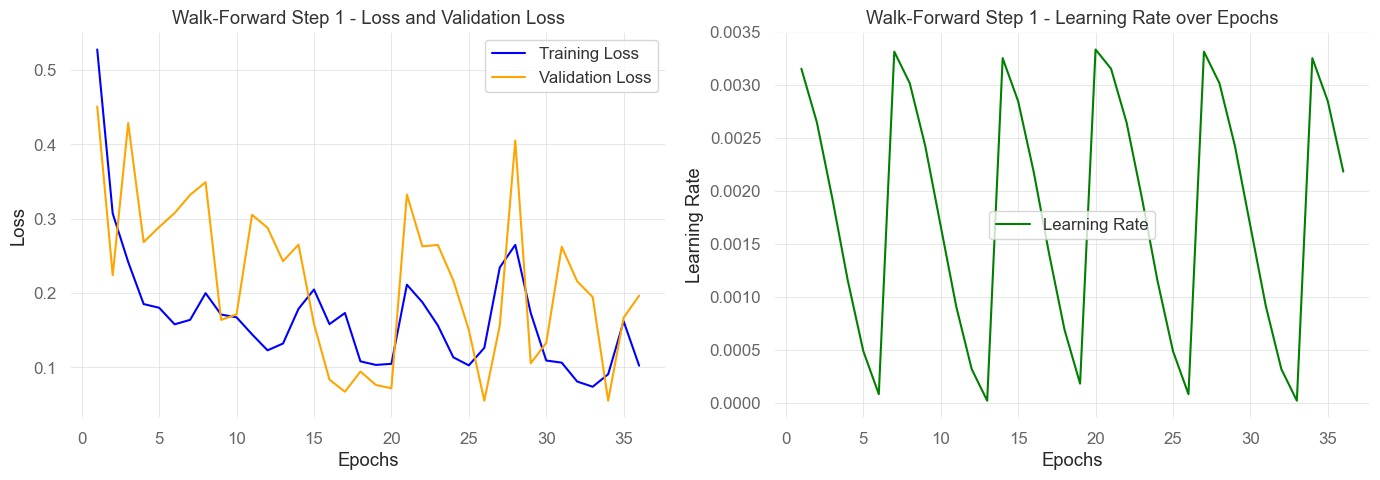

9/9 [==============================] - 1s 4ms/step


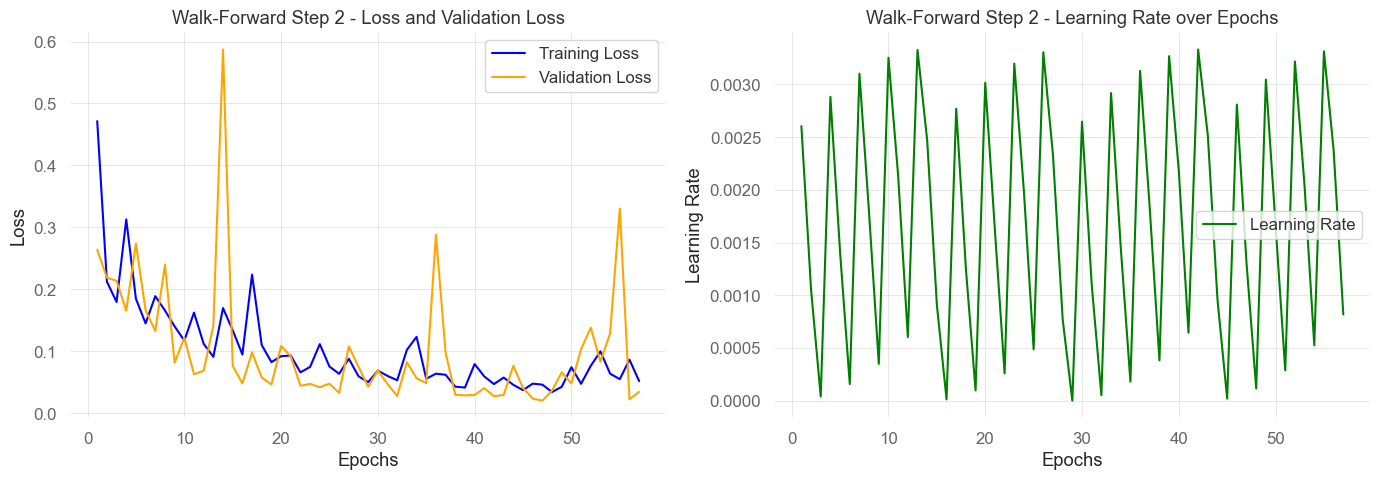

9/9 [==============================] - 1s 7ms/step


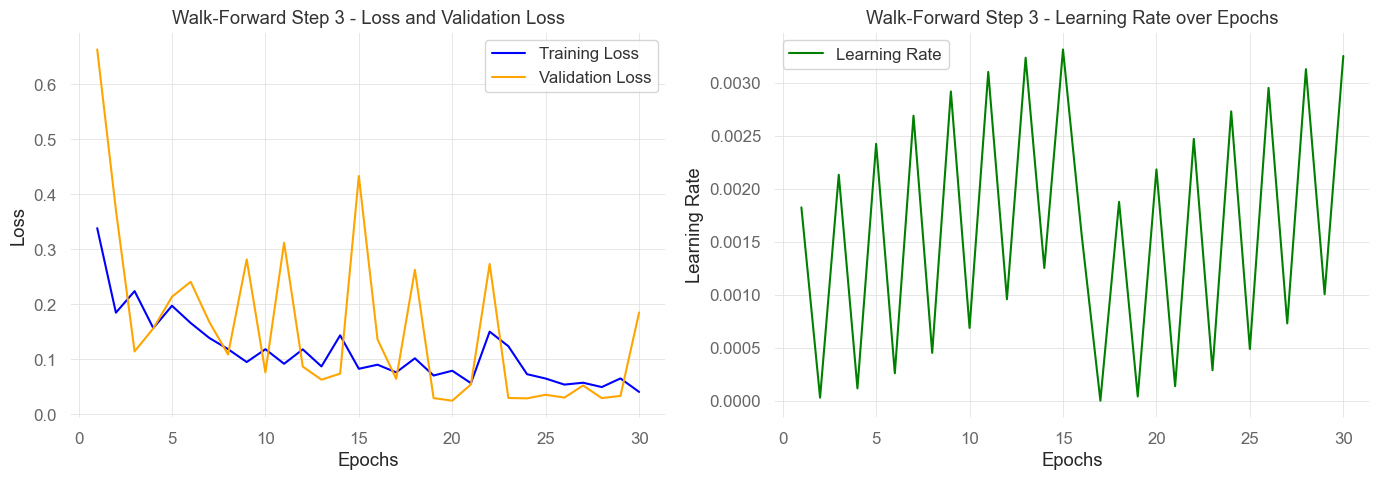

9/9 [==============================] - 1s 6ms/step


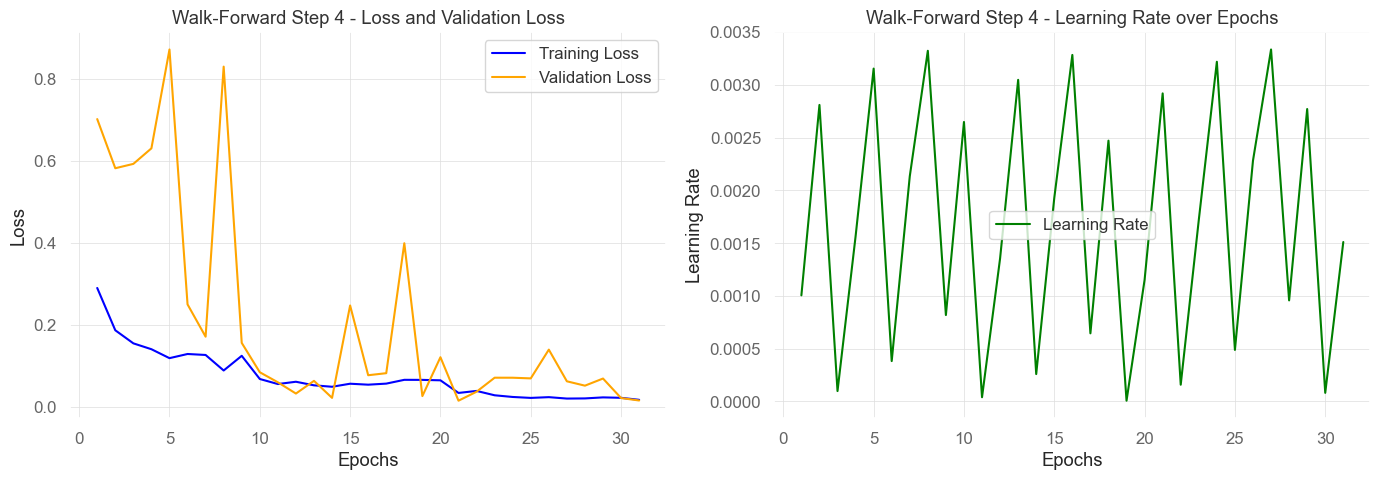

9/9 [==============================] - 1s 5ms/step


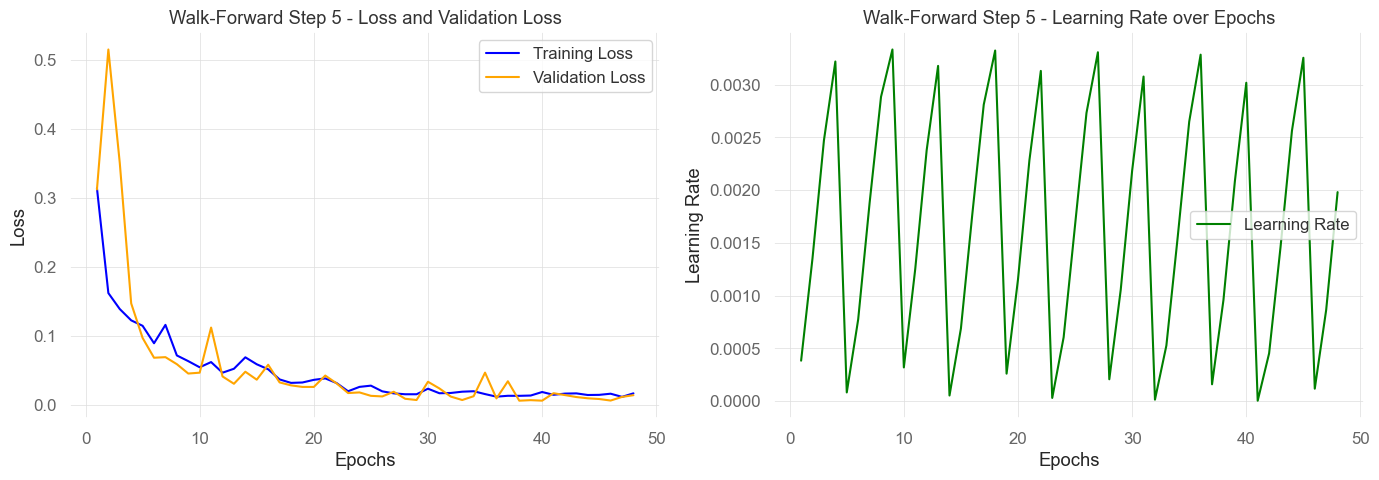

9/9 [==============================] - 1s 6ms/step


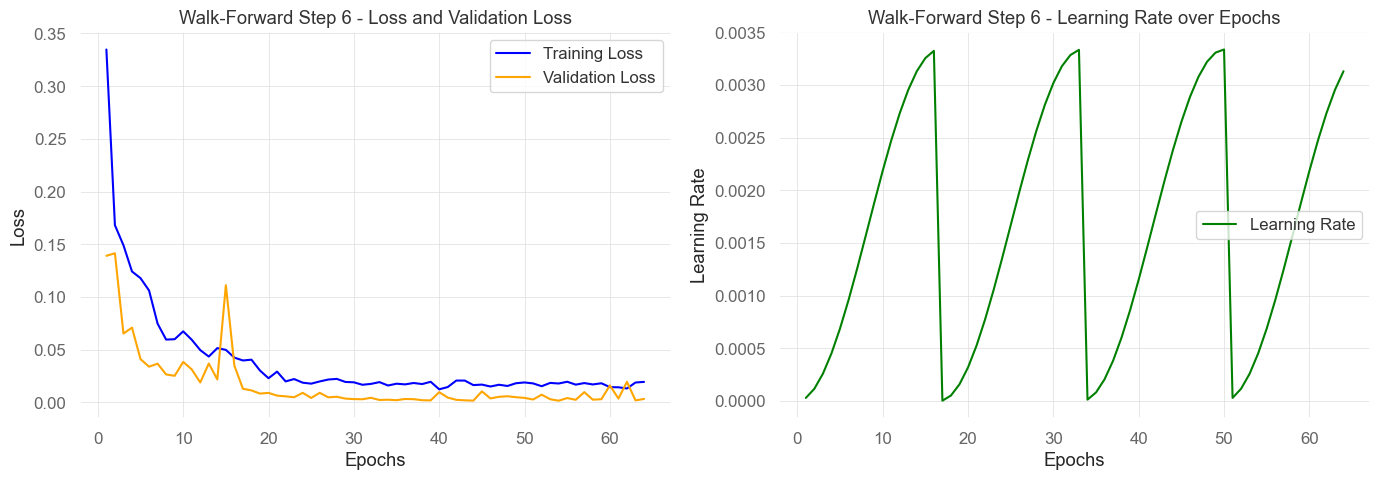

9/9 [==============================] - 1s 6ms/step


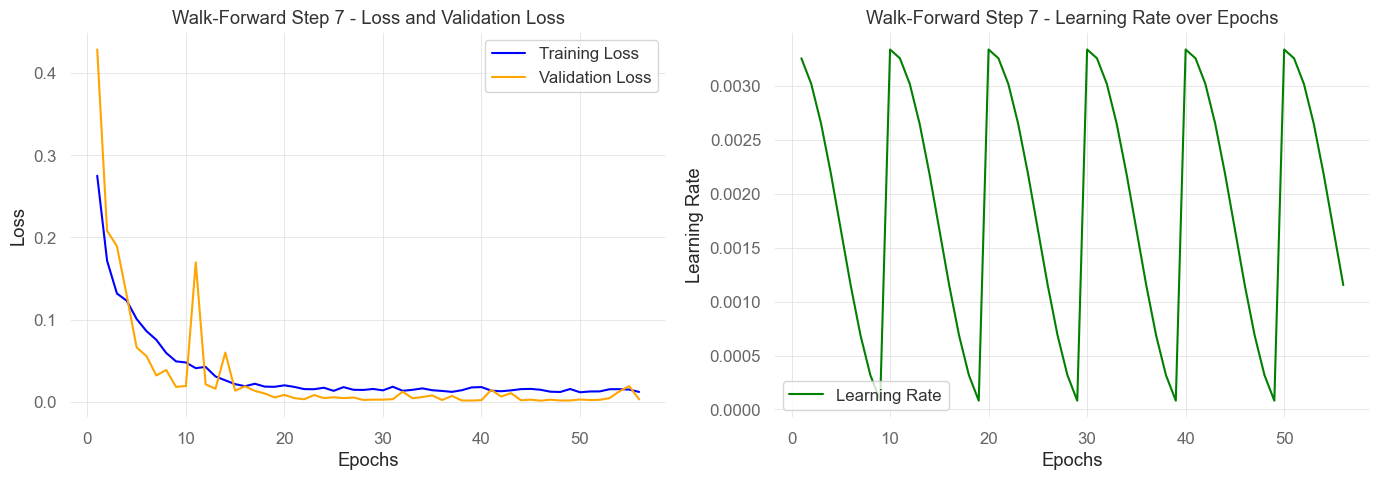

9/9 [==============================] - 1s 9ms/step


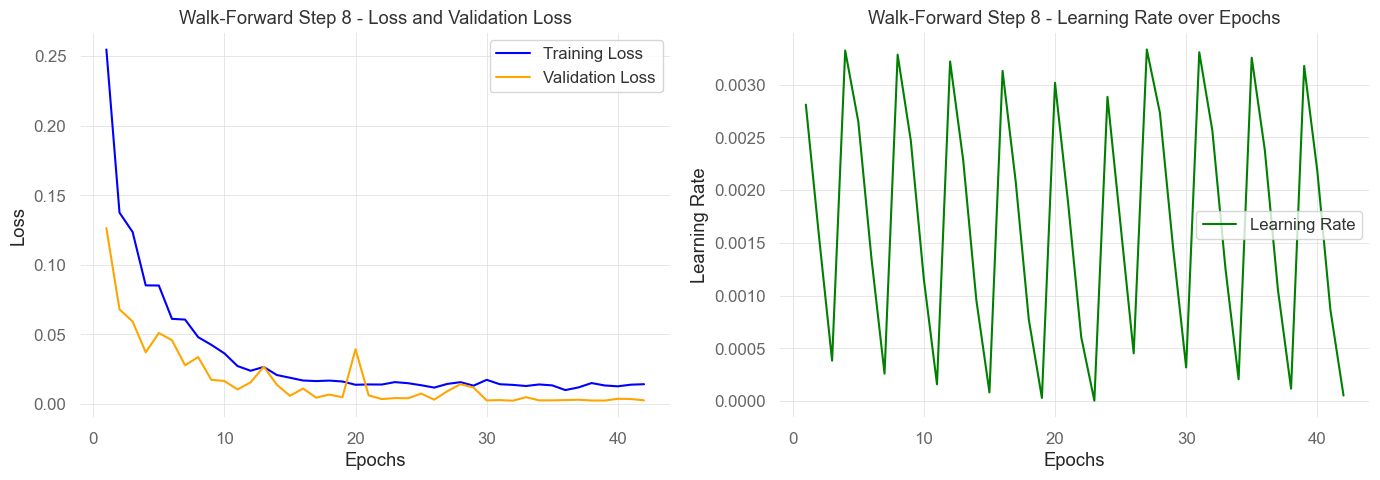

9/9 [==============================] - 1s 6ms/step


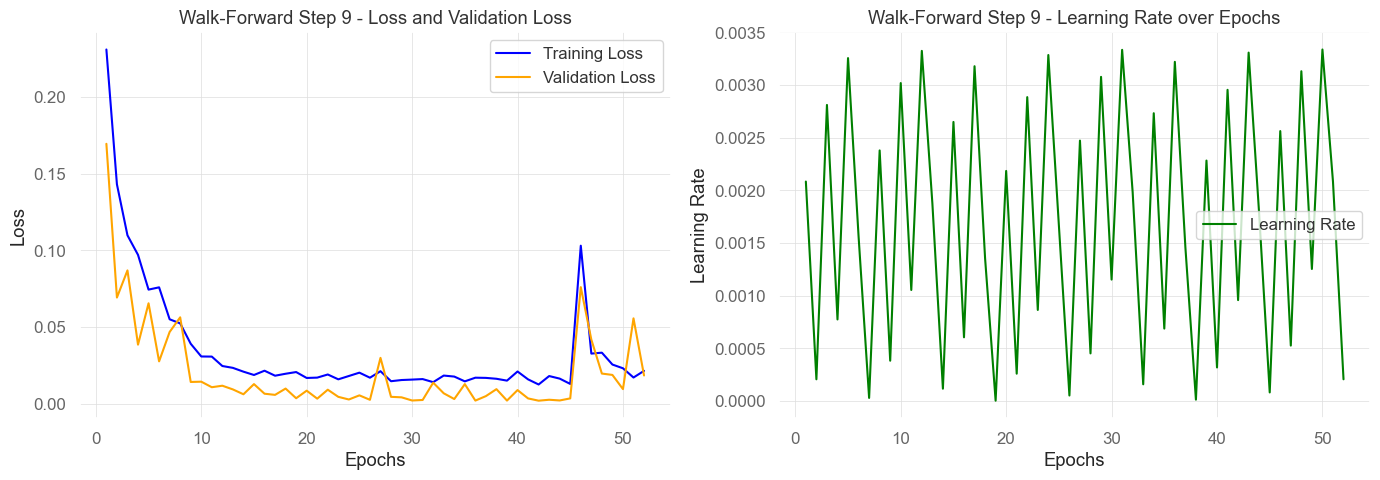

9/9 [==============================] - 1s 4ms/step


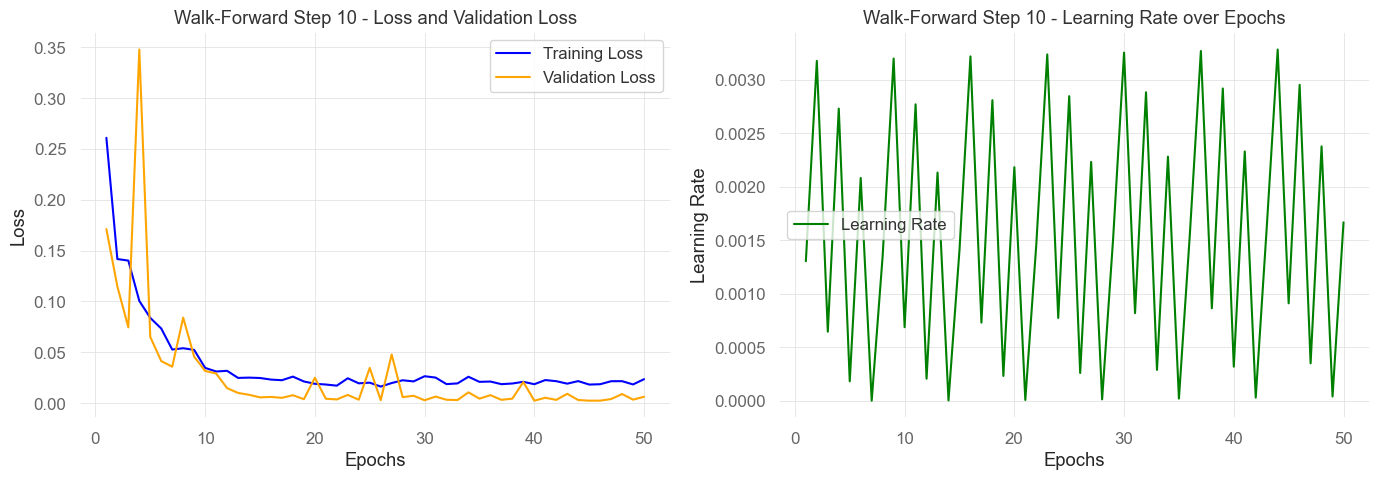

9/9 [==============================] - 1s 5ms/step


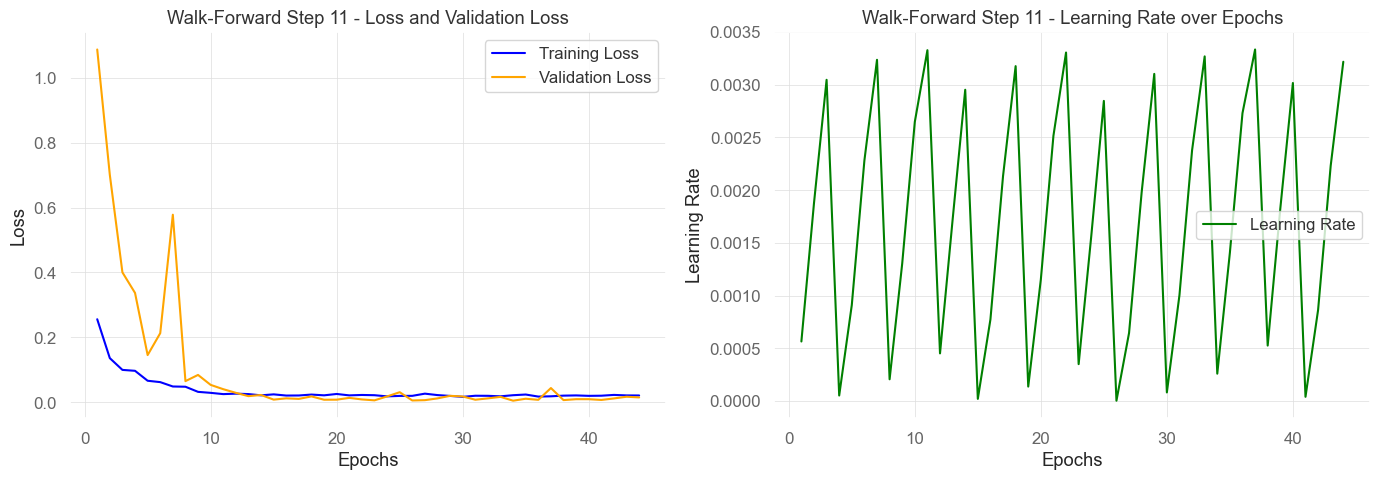

2/2 [==============================] - 0s 4ms/step
Average MSE: 48.64
Average RMSE: 5.32
Average MAE: 4.59
Average MAPE: 2.72%


In [52]:
# Perform Walk-Forward Validation, define test size for each walk-forward step as 10% of the training set
n_test = int(len(lstm_train_scaled) * 0.1)

# Get the best look-back period from hyperparameter tuning
lstm_look_back_best = best_hps.get('lstm_look_back')

# Perform walk-forward validation
walk_forward_validation(lstm_train, n_test, lstm_look_back_best, best_hps)

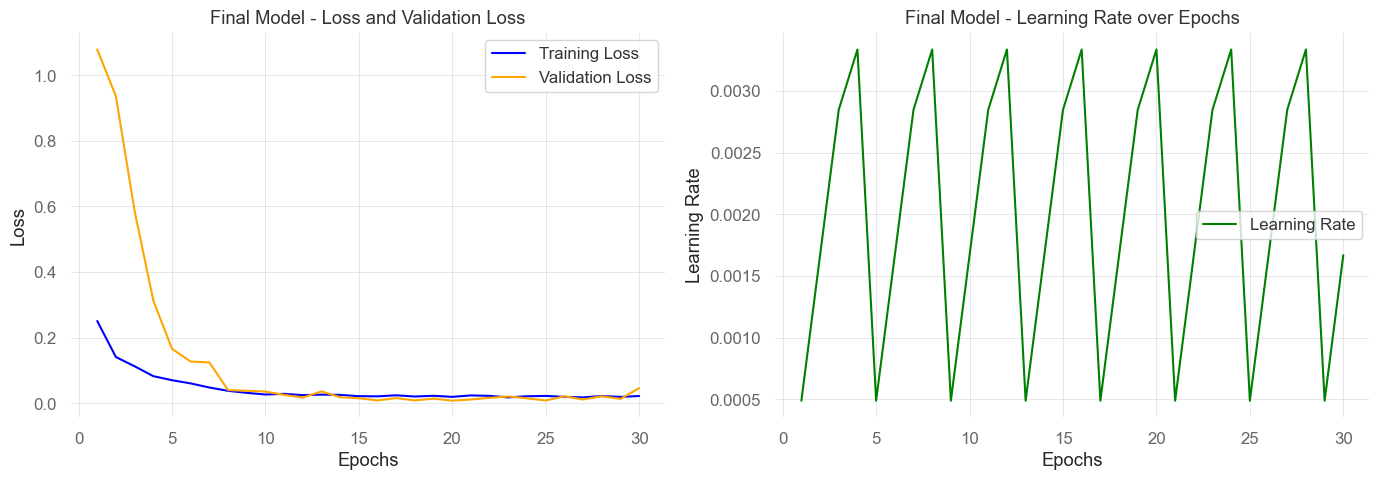

In [53]:
# Train the Final Model on Full Training Data
# Re-fit scalers on the full training data
feature_scaler_full = RobustScaler()
target_scaler_full = RobustScaler()

feature_scaler_full.fit(lstm_train[lstm_numeric_columns])
target_scaler_full.fit(lstm_train[['Close']])

# Transform features and target in the full training data
lstm_train_scaled_full = lstm_train.copy()
lstm_train_scaled_full.loc[:, lstm_numeric_columns] = feature_scaler_full.transform(lstm_train[lstm_numeric_columns])
lstm_train_scaled_full.loc[:, 'Close'] = target_scaler_full.transform(lstm_train[['Close']])

# For the test data, include the last 'lstm_look_back_best' rows from 'lstm_train'
# Avoid resetting index to preserve 'Datetime'
lstm_test_combined = pd.concat([lstm_train.tail(lstm_look_back_best), lstm_test])

# Scale the combined test data
lstm_test_scaled_full = lstm_test_combined.copy()
lstm_test_scaled_full.loc[:, lstm_numeric_columns] = feature_scaler_full.transform(lstm_test_combined[lstm_numeric_columns])
lstm_test_scaled_full.loc[:, 'Close'] = target_scaler_full.transform(lstm_test_combined[['Close']])

# Create datasets for the full training data
lstm_X_train_full, lstm_y_train_full, _ = create_lstm_dataset(lstm_train_scaled_full, lstm_look_back_best)

# Create datasets for the test data
lstm_X_test_full, lstm_y_test_full, _ = create_lstm_dataset(lstm_test_scaled_full, lstm_look_back_best)

# Build and Compile the LSTM Model for full training data
lstm_model_full = build_lstm_model((lstm_look_back_best, len(lstm_numeric_columns)), best_hps)

# Track learning rate
lr_tracker_full = LearningRateLogger()

# Model checkpoint to save the best model
checkpoint_filepath = 'best_model_final.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Record the training time for the final LSTM model
start_time_lstm = time.time()

# Train the final LSTM model
history_full = lstm_model_full.fit(
    lstm_X_train_full,
    lstm_y_train_full,
    epochs=100,
    batch_size=best_hps.get('batch_size'),
    validation_split=0.1,
    callbacks=[early_stopping, lr_tracker_full, model_checkpoint],
    verbose=0
)

# Calculate the training duration in seconds
training_time_lstm = time.time() - start_time_lstm

# Visualize Training Metrics for Final Model
visualize_training_metrics(history_full, lr_tracker_full, fold='Final Model')

# Load the best model
lstm_model_full = load_model(checkpoint_filepath, custom_objects={'Attention': Attention})

In [3]:
# Load the model from the .h5 file
view_model = load_model('best_model_final.h5')

# Display model architecture inline
SVG(model_to_dot(view_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# Save model architecture as an image and display
plot_model(view_model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image(filename='model.png')

# View model summary
print(view_model.summary())
Image

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 20, 16)]     0           []                               
                                                                                                  
 lstm_24 (LSTM)                 (None, 20, 160)      113280      ['input_13[0][0]']               
                                                                                                  
 dropout_24 (Dropout)           (None, 20, 160)      0           ['lstm_24[0][0]']                
                                                                                                  
 lstm_25 (LSTM)                 (None, 20, 32)       24704       ['dropout_24[0][0]']             
                                                                                           

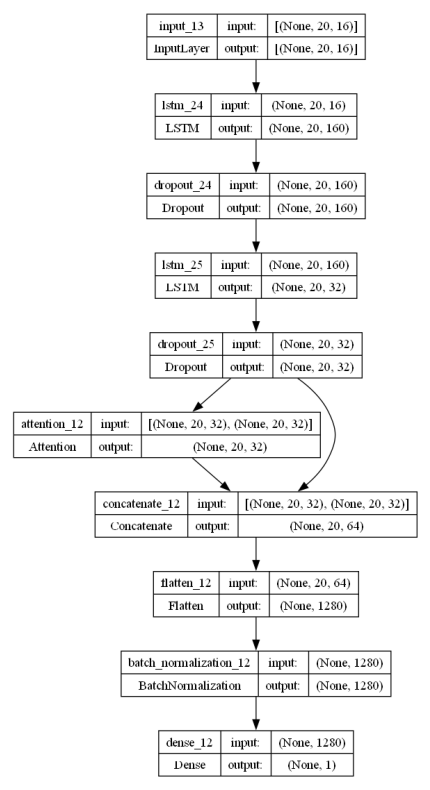

Model defined and compiled.


In [3]:
image_path = 'model.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

print("Model defined and compiled.")

In [54]:
# Make predictions on the test data
lstm_y_pred_full = lstm_model_full.predict(lstm_X_test_full)

# Inverse-transform the predictions and actual values
lstm_y_pred_inv_full = target_scaler_full.inverse_transform(lstm_y_pred_full)
lstm_y_test_inv_full = target_scaler_full.inverse_transform(lstm_y_test_full.reshape(-1, 1))

# Calculate evaluation metrics
mse_full = mean_squared_error(lstm_y_test_inv_full, lstm_y_pred_inv_full)
mae_full = mean_absolute_error(lstm_y_test_inv_full, lstm_y_pred_inv_full)
rmse_full = np.sqrt(mse_full)
mape_full = mean_absolute_percentage_error(lstm_y_test_inv_full, lstm_y_pred_inv_full)

# Prepare the evaluation metrics for LSTM
lstm_metrics = {
    'Model': 'LSTM',
    'MSE': mse_full,
    'RMSE': rmse_full,
    'MAE': mae_full,
    'MAPE(%)': mape_full * 100,
    'Training Time(s)': training_time_lstm
}

# Append the LSTM metrics to the model_evaluation DataFrame
model_evaluation = pd.concat([model_evaluation, pd.DataFrame([lstm_metrics])], ignore_index=True)

# Print the error metrics
print(f'LSTM MSE: {mse_full:.2f}')
print(f'LSTM RMSE: {rmse_full:.2f}')
print(f'LSTM MAE: {mae_full:.2f}')
print(f'LSTM MAPE: {mape_full * 100:.2f}%')

11/11 [==============================] - 1s 5ms/step
LSTM MSE: 4.06
LSTM RMSE: 2.01
LSTM MAE: 1.53
LSTM MAPE: 0.67%


In [55]:
# Get 'Datetime' for test data, skipping the initial look-back period
test_datetimes_full = lstm_test_combined['Datetime'].iloc[lstm_look_back_best:]

# Ensure that the lengths of 'Datetime' and predictions match
min_length = min(len(test_datetimes_full), len(lstm_y_pred_inv_full))
test_datetimes_full = test_datetimes_full.iloc[:min_length]
lstm_y_pred_inv_full = lstm_y_pred_inv_full[:min_length]

# Create a new DataFrame for the predictions with 'Datetime' and 'LSTM_Pred'
lstm_predictions_df_full = pd.DataFrame({
    'Datetime': test_datetimes_full.values,
    'LSTM_Pred': lstm_y_pred_inv_full.flatten()
})

# Remove timezone from 'Datetime' in both DataFrames
lstm_predictions_df_full['Datetime'] = pd.to_datetime(lstm_predictions_df_full['Datetime']).dt.tz_localize(None)
results['Datetime'] = pd.to_datetime(results['Datetime']).dt.tz_localize(None)

# Remove any existing 'LSTM_Pred' column in 'results' to avoid duplication
if 'LSTM_Pred' in results.columns:
    results.drop(columns=['LSTM_Pred'], inplace=True)

# Merge the predictions into the 'results' DataFrame based on 'Datetime'
results = results.merge(lstm_predictions_df_full, on='Datetime', how='left')

In [56]:
# Check for NaN values in the merged columns
print("NaN values after merging:")
print(results[['Close', 'ARIMA_Pred', 'LSTM_Pred']].isna().sum())

# Remove all rows with null values in 'Close', 'ARIMA_Pred', or 'LSTM_Pred'
results_clean = results.dropna(subset=['Close', 'ARIMA_Pred', 'LSTM_Pred'])

NaN values after merging:
Close         0
ARIMA_Pred    0
LSTM_Pred     0
dtype: int64


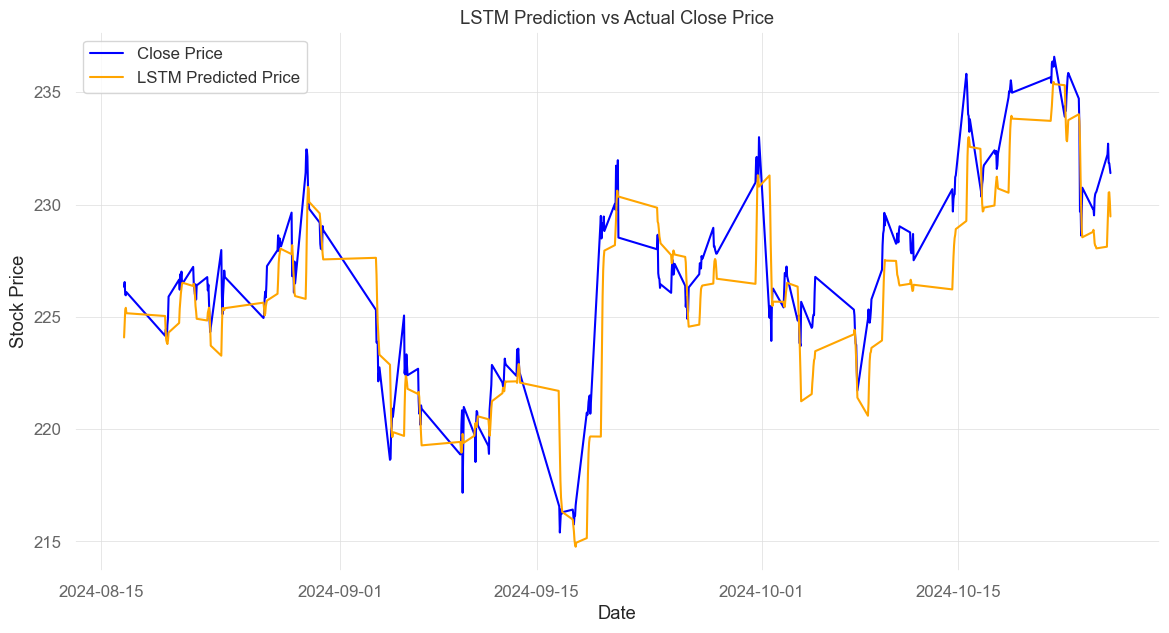

In [57]:
# Create a line graph for 'Close', 'ARIMA_Pred', and 'LSTM_Pred'
plt.figure(figsize=(14, 7))

# Plot 'Close' prices
plt.plot(results_clean['Datetime'], results_clean['Close'], label='Close Price', color='blue')

# Plot 'LSTM_Pred' predictions
plt.plot(results_clean['Datetime'], results_clean['LSTM_Pred'], label='LSTM Predicted Price', color='orange')

# Add labels and legend
plt.title('LSTM Prediction vs Actual Close Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Show the graph
plt.show()

#### Mixture of Experts

In [58]:
# Normalize or standardize feature columns using RobustScaler
feature_columns = ['VIX_close']
scaler = RobustScaler()
features = scaler.fit_transform(results_clean[feature_columns].values)

# Normalize predictions using RobustScaler
predictions_scaler = RobustScaler()
predictions = predictions_scaler.fit_transform(results_clean[['ARIMA_Pred', 'LSTM_Pred']].values)

In [59]:
# Combine ARIMA, LSTM Predictions, and Features into the Gating Network Input
gating_input = np.concatenate([predictions, features], axis=1)

In [60]:
# Build the Gating Network
def build_gating_network(input_shape, lstm_units=64):
    inputs = Input(shape=input_shape)

    # Add an LSTM layer to capture temporal dependencies
    x = LSTM(lstm_units, return_sequences=False)(inputs)
    
    # Add dense layers with regularization (L2)
    x = Dense(32, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = Dense(16, activation='relu', kernel_regularizer=l2(1e-5))(x)

    # Output layer with softmax to compute weights for ARIMA and LSTM
    weights = Dense(2, activation='softmax', kernel_regularizer=l2(1e-5),
                    kernel_constraint=MinMaxNorm(min_value=0.1, max_value=0.9))(x)

    # Define the model
    model = Model(inputs=inputs, outputs=weights)
    model.compile(optimizer='adam', loss='huber_loss', metrics=['mae', 'mape'])

    return model

# Prepare input for LSTM
timesteps = 1
gating_input_reshaped = gating_input.reshape((gating_input.shape[0], timesteps, gating_input.shape[1]))

# Build the gating model
gating_model = build_gating_network(input_shape=(timesteps, gating_input.shape[1]))

In [61]:
# Smooth Weight Transitions Using Momentum-Based Approach
momentum = 0.8

def smooth_weights(prev_weights, current_weights, momentum=0.6):
    return momentum * prev_weights + (1 - momentum) * current_weights

# Train the Gating Network
# Use actual Close prices as target for training
close_prices = results_clean['Close'].values.reshape(-1, 1)

# Track training time
start_time_moe = time.time()  # Start time
history = gating_model.fit(
    gating_input_reshaped, 
    close_prices, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1
)
# Calculate training time
training_time_moe = time.time() - start_time_moe

Epoch 1/100
10/10 [==============================] - 2s 48ms/step - loss: 224.9975 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8195 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 224.9975 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8194 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 224.9974 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8194 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 224.9974 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8193 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 224.9973 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8193 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 6/100
10/10 [==============================] - 0s 11ms/step - loss: 224.9973 - mae: 225.4969 - mape: 99.7787 - val

10/10 [==============================] - 0s 11ms/step - loss: 224.9969 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8188 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 94/100
10/10 [==============================] - 0s 8ms/step - loss: 224.9969 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8188 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 95/100
10/10 [==============================] - 0s 8ms/step - loss: 224.9969 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8188 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 96/100
10/10 [==============================] - 0s 8ms/step - loss: 224.9969 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8188 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 97/100
10/10 [==============================] - 0s 8ms/step - loss: 224.9969 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8188 - val_mae: 232.3188 - val_mape: 99.7852
Epoch 98/100
10/10 [==============================] - 0s 9ms/step - loss: 224.9969 - mae: 225.4969 - mape: 99.7787 - val_loss: 231.8

In [62]:
# Use the Gating Network for Predictions
gating_weights = gating_model.predict(gating_input_reshaped)

# Apply smoothing to the weights
smoothed_weights = np.zeros_like(gating_weights)
smoothed_weights[0] = gating_weights[0]  # No smoothing for the first entry

# Smooth the weights for subsequent time steps
for t in range(1, len(gating_weights)):
    smoothed_weights[t] = smooth_weights(smoothed_weights[t-1], gating_weights[t], momentum)

11/11 [==============================] - 0s 2ms/step


In [63]:
# Use Smoothed Weights to Compute Final Predictions
final_predictions = smoothed_weights[:, 0] * results_clean['ARIMA_Pred'].values + smoothed_weights[:, 1] * results_clean['LSTM_Pred'].values

# Add the final predictions to results_clean
results_clean['MoE_Pred'] = final_predictions

# Evaluate the Model Performance
mse_moe = mean_squared_error(results_clean['Close'], results_clean['MoE_Pred'])
rmse_moe = np.sqrt(mse_moe)
mae_moe = mean_absolute_error(results_clean['Close'], results_clean['MoE_Pred'])
mape_moe = mean_absolute_percentage_error(results_clean['Close'], results_clean['MoE_Pred'])

# Prepare the evaluation metrics for MoE
moe_metrics = {
    'Model': 'MoE',
    'MSE': mse_moe,
    'RMSE': rmse_moe,
    'MAE': mae_moe,
    'MAPE(%)': mape_moe * 100,
    'Training Time(s)': training_time_moe
}

# Append the MoE metrics to the model_evaluation DataFrame
model_evaluation = pd.concat([model_evaluation, pd.DataFrame([moe_metrics])], ignore_index=True)

# Print the error metrics
print(f'MoE MSE: {mse_moe:.2f}')
print(f'MoE RMSE: {rmse_moe:.2f}')
print(f'MoE MAE: {mae_moe:.2f}')
print(f'MoE MAPE: {mape_moe * 100:.2f}%')

MoE MSE: 7.89
MoE RMSE: 2.81
MoE MAE: 2.23
MoE MAPE: 0.99%


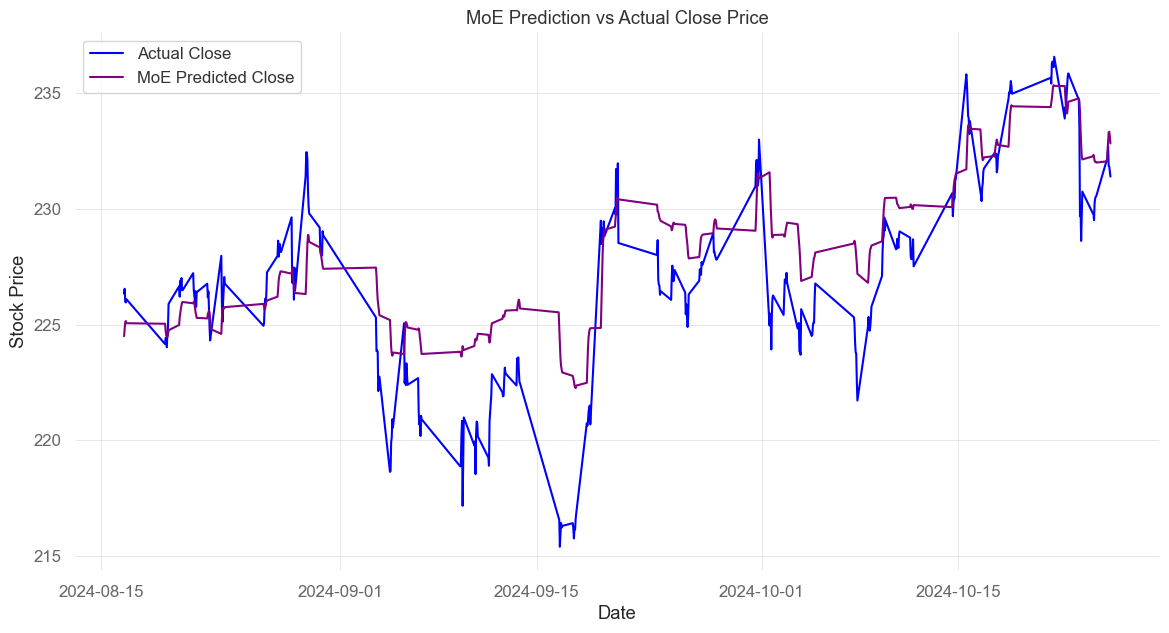

In [64]:
# Plot the Results
plt.figure(figsize=(14, 7))
plt.plot(results_clean['Datetime'], results_clean['Close'], label='Actual Close', color='blue')
plt.plot(results_clean['Datetime'], results_clean['MoE_Pred'], label='MoE Predicted Close', color='purple')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('MoE Prediction vs Actual Close Price')
plt.legend()
plt.grid(True)
plt.show()

## Part 4: Results

### Model Performance

In [65]:
model_evaluation

Model        MSE      RMSE       MAE   MAPE(%)  Training Time(s)
0  ARIMA_1D  24.409101  4.940557  3.966969  1.740957          0.036998
1  ARIMA_2D  30.869931  5.556072  4.432255  1.978561          0.188522
2      LSTM   4.057699  2.014373  1.531557  0.673719         48.542027
3       MoE   7.885078  2.808038  2.227380  0.993305         11.173000

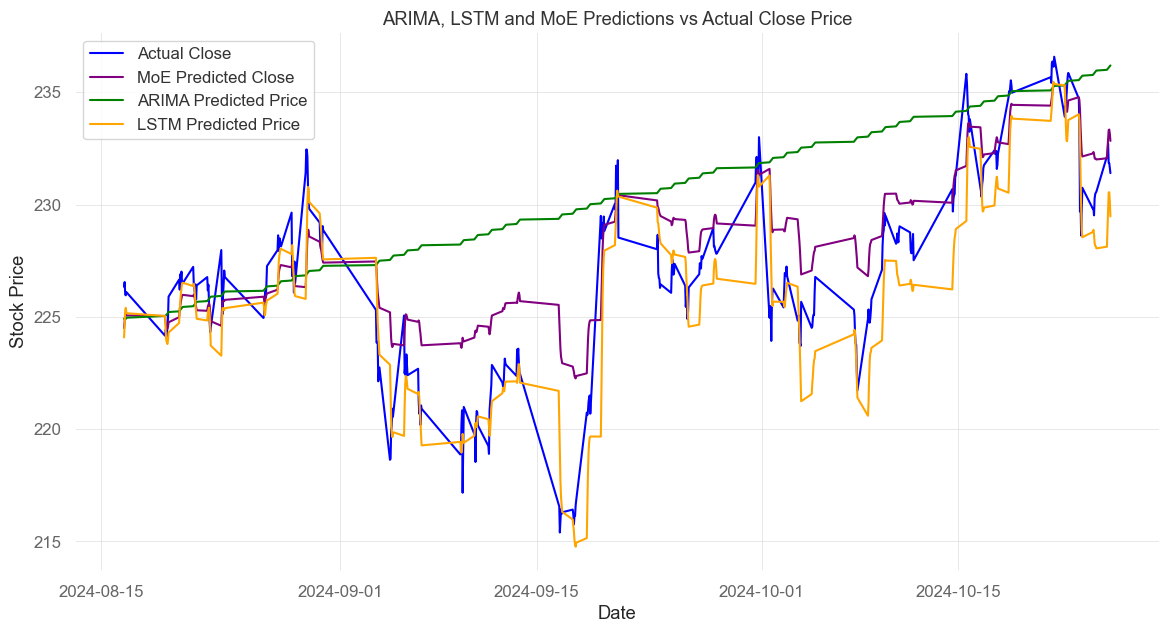

In [66]:
# Plot the Results
plt.figure(figsize=(14, 7))
plt.plot(results_clean['Datetime'], results_clean['Close'], label='Actual Close', color='blue')
plt.plot(results_clean['Datetime'], results_clean['MoE_Pred'], label='MoE Predicted Close', color='purple')
plt.plot(results_clean['Datetime'], results_clean['ARIMA_Pred'], label='ARIMA Predicted Price', color='green')
plt.plot(results_clean['Datetime'], results_clean['LSTM_Pred'], label='LSTM Predicted Price', color='orange')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ARIMA, LSTM and MoE Predictions vs Actual Close Price')
plt.legend()
plt.grid(True)
plt.show()

### Trading Strategy

In [67]:
# Make a deep copy of results_clean to avoid modifying the original DataFrame
results_clean = results_clean.copy(deep=True)

# Shift 'ARIMA_Pred', 'LSTM_Pred', and 'MoE_Pred' down by one to get previous period's predictions
results_clean['ARIMA_Pred_Previous'] = results_clean['ARIMA_Pred'].shift(1)
results_clean['LSTM_Pred_Previous'] = results_clean['LSTM_Pred'].shift(1)
results_clean['MoE_Pred_Previous'] = results_clean['MoE_Pred'].shift(1)

# Shift 'Open' price down by one period to get the next day's 'Open' price for action
results_clean['Open_Next'] = results_clean['Open'].shift(-1)

# Drop rows with NaN values resulting from shifting
results_clean = results_clean.dropna(subset=['ARIMA_Pred', 'ARIMA_Pred_Previous', 'LSTM_Pred', 'LSTM_Pred_Previous', 'MoE_Pred', 'MoE_Pred_Previous', 'Open_Next'])

# Step 2: Initialize Portfolio Values and Positions
initial_capital = 10000
benchmark_shares = initial_capital / results_clean.iloc[0]['Close']
results_clean['Benchmark_Portfolio_Value'] = benchmark_shares * results_clean['Close']

# Initialize positions and cash for all strategies
results_clean['ARIMA_Position'] = 0.0
results_clean['ARIMA_Cash'] = initial_capital
results_clean['ARIMA_Portfolio_Value'] = np.nan

results_clean['LSTM_Position'] = 0.0
results_clean['LSTM_Cash'] = initial_capital
results_clean['LSTM_Portfolio_Value'] = np.nan

results_clean['MoE_Position'] = 0.0
results_clean['MoE_Cash'] = initial_capital
results_clean['MoE_Portfolio_Value'] = np.nan

# Set initial positions and cash
first_index = results_clean.index[0]
results_clean.at[first_index, 'ARIMA_Position'] = 0.0
results_clean.at[first_index, 'ARIMA_Cash'] = initial_capital
results_clean.at[first_index, 'LSTM_Position'] = 0.0
results_clean.at[first_index, 'LSTM_Cash'] = initial_capital
results_clean.at[first_index, 'MoE_Position'] = 0.0
results_clean.at[first_index, 'MoE_Cash'] = initial_capital

# Convert 'ARIMA_Cash', 'LSTM_Cash', and 'MoE_Cash' columns to float64
results_clean['ARIMA_Cash'] = results_clean['ARIMA_Cash'].astype('float64')
results_clean['LSTM_Cash'] = results_clean['LSTM_Cash'].astype('float64')
results_clean['MoE_Cash'] = results_clean['MoE_Cash'].astype('float64')

In [68]:
# Implement the Trading Strategy
for t in range(len(results_clean) - 1):
    current_index = results_clean.index[t]
    next_index = results_clean.index[t + 1]

    # Get current data
    current_close = results_clean.at[current_index, 'Close']
    next_open = results_clean.at[next_index, 'Open']

    # ------------------ ARIMA Strategy ------------------ #
    arima_pred_current = results_clean.at[current_index, 'ARIMA_Pred']
    arima_pred_previous = results_clean.at[current_index, 'ARIMA_Pred_Previous']
    arima_position_t = results_clean.at[current_index, 'ARIMA_Position']
    arima_cash_t = results_clean.at[current_index, 'ARIMA_Cash']

    # Calculate portfolio value at time t
    arima_portfolio_value_t = arima_cash_t + arima_position_t * current_close
    results_clean.at[current_index, 'ARIMA_Portfolio_Value'] = arima_portfolio_value_t

    # Decide on trade to execute at next open price
    if arima_pred_current > arima_pred_previous:
        # Buy at next open price
        if arima_cash_t > 0:
            shares_to_buy = arima_cash_t / next_open
            arima_position_t_plus_1 = arima_position_t + shares_to_buy
            arima_cash_t_plus_1 = arima_cash_t - shares_to_buy * next_open
        else:
            # No cash to buy
            arima_position_t_plus_1 = arima_position_t
            arima_cash_t_plus_1 = arima_cash_t
    elif arima_pred_current < arima_pred_previous:
        # Sell at next open price
        if arima_position_t > 0:
            arima_cash_t_plus_1 = arima_cash_t + arima_position_t * next_open
            arima_position_t_plus_1 = 0.0
        else:
            # No position to sell
            arima_cash_t_plus_1 = arima_cash_t
            arima_position_t_plus_1 = arima_position_t
    else:
        # No action if predictions are equal
        arima_position_t_plus_1 = arima_position_t
        arima_cash_t_plus_1 = arima_cash_t

    # Update next day's position and cash
    results_clean.at[next_index, 'ARIMA_Position'] = arima_position_t_plus_1
    results_clean.at[next_index, 'ARIMA_Cash'] = arima_cash_t_plus_1

    # ------------------ LSTM Strategy ------------------ #
    lstm_pred_current = results_clean.at[current_index, 'LSTM_Pred']
    lstm_pred_previous = results_clean.at[current_index, 'LSTM_Pred_Previous']
    lstm_position_t = results_clean.at[current_index, 'LSTM_Position']
    lstm_cash_t = results_clean.at[current_index, 'LSTM_Cash']

    # Calculate portfolio value at time t
    lstm_portfolio_value_t = lstm_cash_t + lstm_position_t * current_close
    results_clean.at[current_index, 'LSTM_Portfolio_Value'] = lstm_portfolio_value_t

    # Decide on trade to execute at next open price
    if lstm_pred_current > lstm_pred_previous:
        # Buy at next open price
        if lstm_cash_t > 0:
            shares_to_buy = lstm_cash_t / next_open
            lstm_position_t_plus_1 = lstm_position_t + shares_to_buy
            lstm_cash_t_plus_1 = lstm_cash_t - shares_to_buy * next_open
        else:
            # No cash to buy
            lstm_position_t_plus_1 = lstm_position_t
            lstm_cash_t_plus_1 = lstm_cash_t
    elif lstm_pred_current < lstm_pred_previous:
        # Sell at next open price
        if lstm_position_t > 0:
            lstm_cash_t_plus_1 = lstm_cash_t + lstm_position_t * next_open
            lstm_position_t_plus_1 = 0.0
        else:
            # No position to sell
            lstm_cash_t_plus_1 = lstm_cash_t
            lstm_position_t_plus_1 = lstm_position_t
    else:
        # No action if predictions are equal
        lstm_position_t_plus_1 = lstm_position_t
        lstm_cash_t_plus_1 = lstm_cash_t

    # Update next day's position and cash
    results_clean.at[next_index, 'LSTM_Position'] = lstm_position_t_plus_1
    results_clean.at[next_index, 'LSTM_Cash'] = lstm_cash_t_plus_1

    # ------------------ MoE Strategy ------------------ #
    moe_pred_current = results_clean.at[current_index, 'MoE_Pred']
    moe_pred_previous = results_clean.at[current_index, 'MoE_Pred_Previous']
    moe_position_t = results_clean.at[current_index, 'MoE_Position']
    moe_cash_t = results_clean.at[current_index, 'MoE_Cash']

    # Calculate portfolio value at time t
    moe_portfolio_value_t = moe_cash_t + moe_position_t * current_close
    results_clean.at[current_index, 'MoE_Portfolio_Value'] = moe_portfolio_value_t

    # Trading strategy based on MoE predictions
    if moe_pred_current > moe_pred_previous:
        # Buy at next open price
        if moe_cash_t > 0:
            shares_to_buy = moe_cash_t / next_open
            moe_position_t_plus_1 = moe_position_t + shares_to_buy
            moe_cash_t_plus_1 = moe_cash_t - shares_to_buy * next_open
        else:
            # No cash to buy
            moe_position_t_plus_1 = moe_position_t
            moe_cash_t_plus_1 = moe_cash_t
    elif moe_pred_current < moe_pred_previous:
        # Sell at next open price
        if moe_position_t > 0:
            moe_cash_t_plus_1 = moe_cash_t + moe_position_t * next_open
            moe_position_t_plus_1 = 0.0
        else:
            # No position to sell
            moe_cash_t_plus_1 = moe_cash_t
            moe_position_t_plus_1 = moe_position_t
    else:
        # No action if predictions are equal
        moe_position_t_plus_1 = moe_position_t
        moe_cash_t_plus_1 = moe_cash_t

    # Update next day's position and cash
    results_clean.at[next_index, 'MoE_Position'] = moe_position_t_plus_1
    results_clean.at[next_index, 'MoE_Cash'] = moe_cash_t_plus_1

In [69]:
# Calculate Portfolio Value for the Last Day
last_index = results_clean.index[-1]
last_close = results_clean.at[last_index, 'Close']

# ARIMA Strategy
arima_position_last = results_clean.at[last_index, 'ARIMA_Position']
arima_cash_last = results_clean.at[last_index, 'ARIMA_Cash']
arima_portfolio_value_last = arima_cash_last + arima_position_last * last_close
results_clean.at[last_index, 'ARIMA_Portfolio_Value'] = arima_portfolio_value_last

# LSTM Strategy
lstm_position_last = results_clean.at[last_index, 'LSTM_Position']
lstm_cash_last = results_clean.at[last_index, 'LSTM_Cash']
lstm_portfolio_value_last = lstm_cash_last + lstm_position_last * last_close
results_clean.at[last_index, 'LSTM_Portfolio_Value'] = lstm_portfolio_value_last

# MoE Strategy
moe_position_last = results_clean.at[last_index, 'MoE_Position']
moe_cash_last = results_clean.at[last_index, 'MoE_Cash']
moe_portfolio_value_last = moe_cash_last + moe_position_last * last_close
results_clean.at[last_index, 'MoE_Portfolio_Value'] = moe_portfolio_value_last

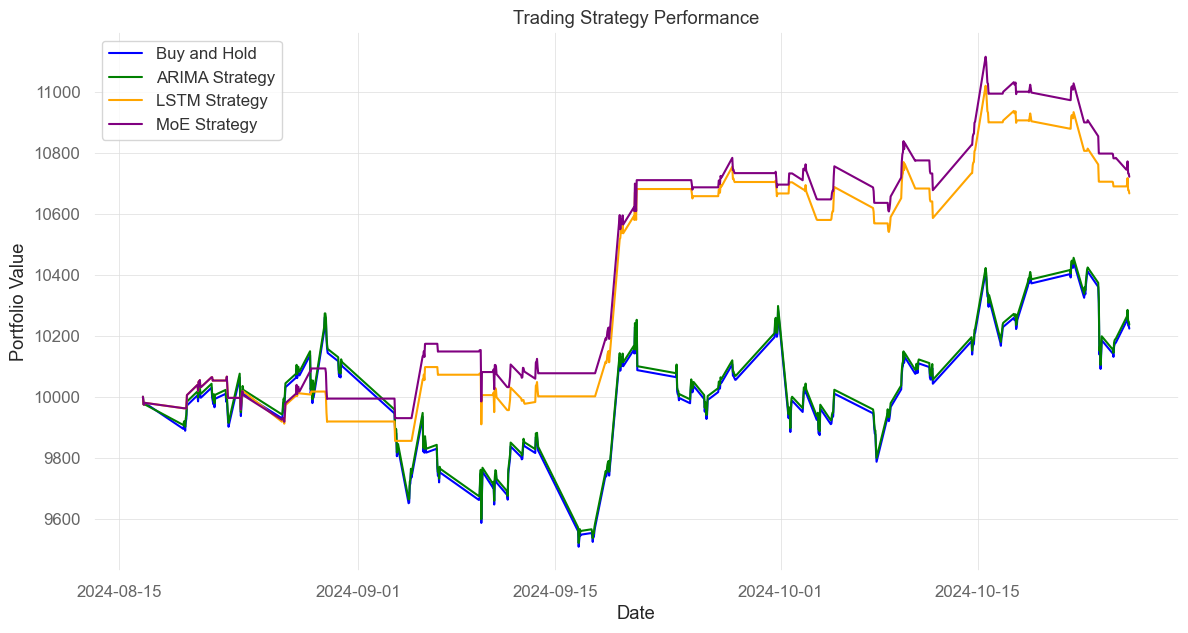

In [70]:
# Plot the Results
plt.figure(figsize=(14, 7))
plt.plot(results_clean['Datetime'], results_clean['Benchmark_Portfolio_Value'], label='Buy and Hold', color='blue')
plt.plot(results_clean['Datetime'], results_clean['ARIMA_Portfolio_Value'], label='ARIMA Strategy', color='green')
plt.plot(results_clean['Datetime'], results_clean['LSTM_Portfolio_Value'], label='LSTM Strategy', color='orange')
plt.plot(results_clean['Datetime'], results_clean['MoE_Portfolio_Value'], label='MoE Strategy', color='purple')

plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Trading Strategy Performance')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
results_clean.to_csv("Result.csv")

In [2]:
results_clean = pd.read_csv("Result.csv")

### Financial Performance

In [4]:
qs.extend_pandas()
results_analysis = results_clean

# Conversion time
results_analysis['Datetime'] = pd.to_datetime(results_analysis['Datetime'])
results_analysis.set_index('Datetime', inplace=True)

# Calculating Risk-Free Rate based on 2 years data
Riskfree_rate = results_analysis['IRX_close'].mean() / 100 / 1764 * len(results_analysis)

In [5]:
results_analysis['Benchmark_Returns'] = results_analysis['Benchmark_Portfolio_Value'].pct_change().fillna(0)
results_analysis['ARIMA_Returns'] = results_analysis['ARIMA_Portfolio_Value'].pct_change().fillna(0)
results_analysis['LSTM_Returns'] = results_analysis['LSTM_Portfolio_Value'].pct_change().fillna(0)
results_analysis['MoE_Returns'] = results_analysis['MoE_Portfolio_Value'].pct_change().fillna(0)

                           Strategy
-------------------------  ----------
Start Period               2024-08-16
End Period                 2024-10-25
Risk-Free Rate             0.92%
Time in Market             100.0%

Cumulative Return          2.24%
CAGR﹪                     8.29%

Sharpe                     0.12
Prob. Sharpe Ratio         53.58%
Smart Sharpe               0.11
Sortino                    0.17
Smart Sortino              0.15
Sortino/√2                 0.12
Smart Sortino/√2           0.11
Omega                      1.03

Max Drawdown               -7.33%
Longest DD Days            33
Volatility (ann.)          9.07%
Calmar                     1.13
Skew                       0.27
Kurtosis                   12.99

Expected Daily %           0.01%
Expected Monthly %         0.74%
Expected Yearly %          2.24%
Kelly Criterion            2.45%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.93%
Expected Shortfall (cVaR)  -0.93%

Max Consecutive Wins       8


None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2024-08-29  2024-09-16  2024-09-30    33     -7.334912         -7.091848
2  2024-10-01  2024-10-07  2024-10-14    14     -4.841201         -4.478540
3  2024-10-22  2024-10-23  2024-10-25     4     -3.364615         -2.984448
4  2024-10-15  2024-10-16  2024-10-21     7     -2.323811         -2.219914
5  2024-08-28  2024-08-28  2024-08-28     1     -1.550252         -1.371710

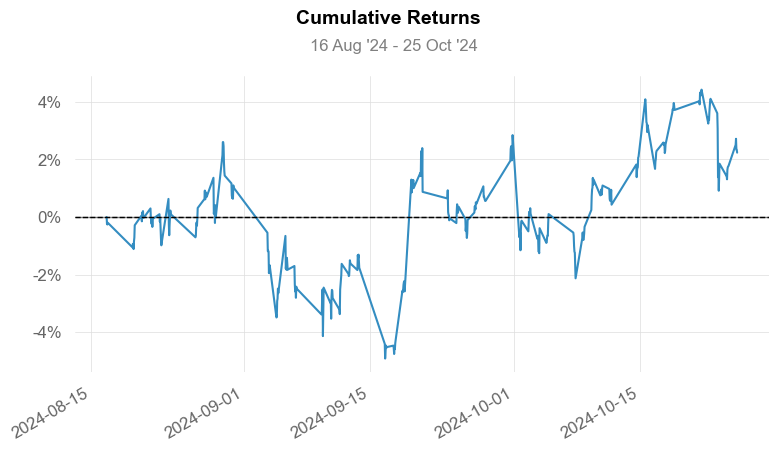

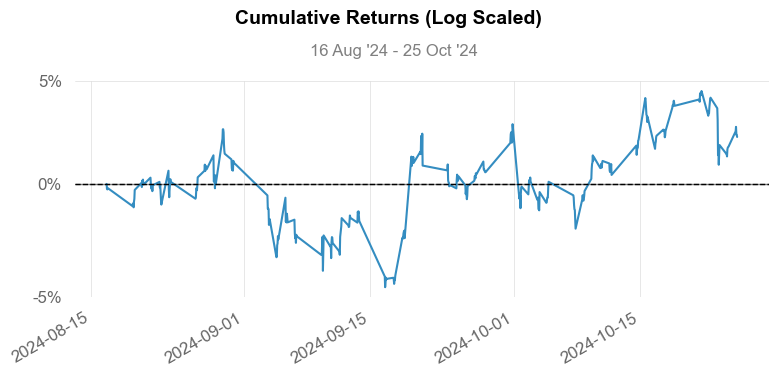

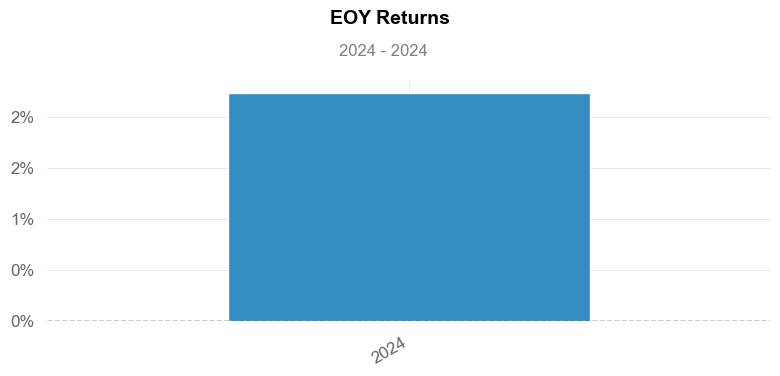

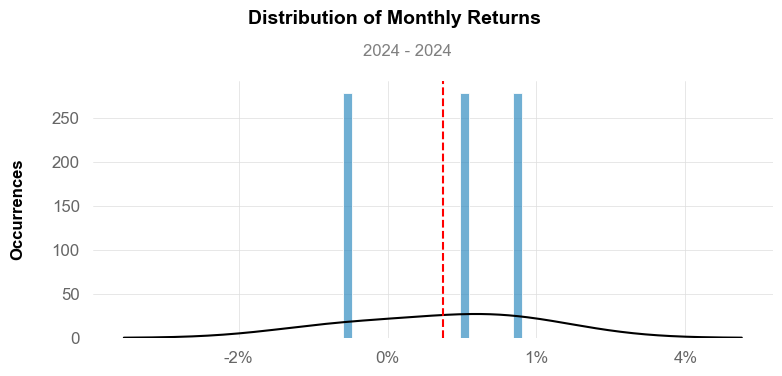

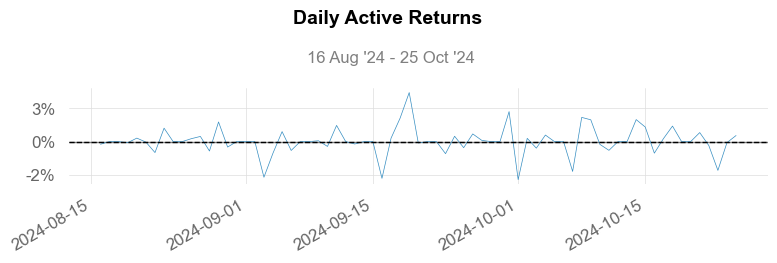

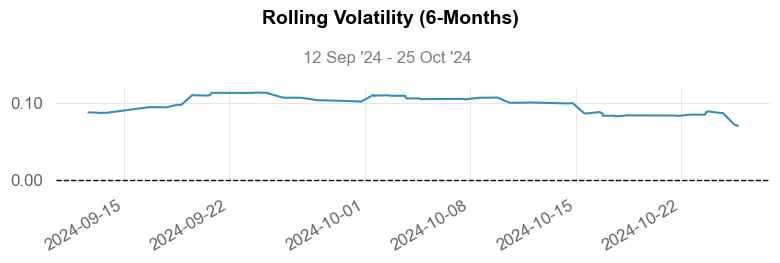

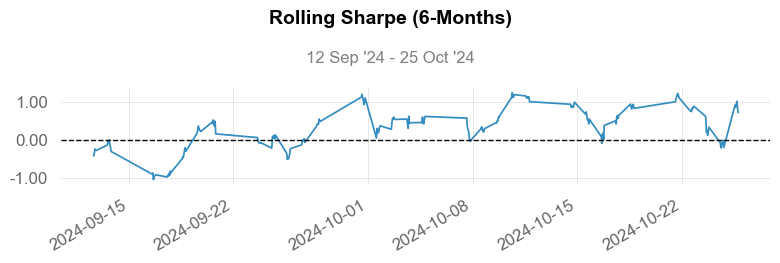

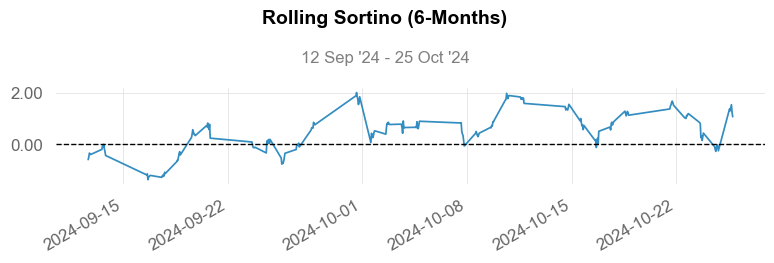

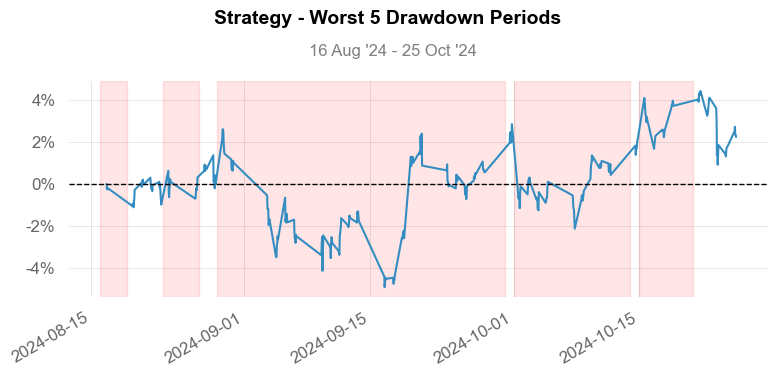

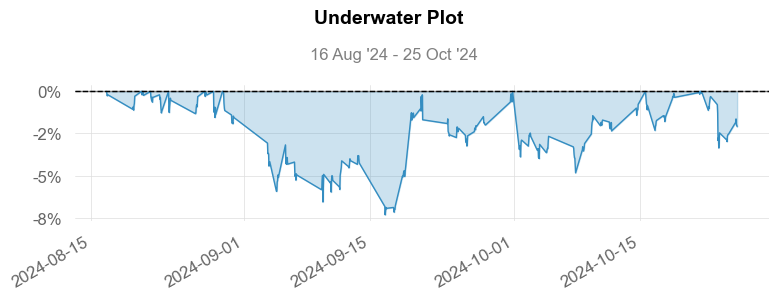

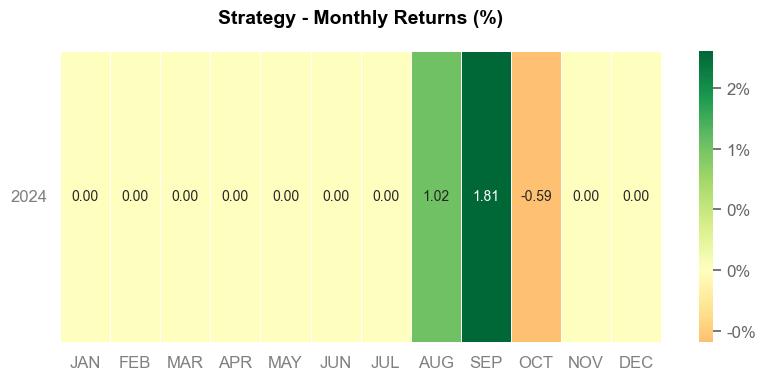

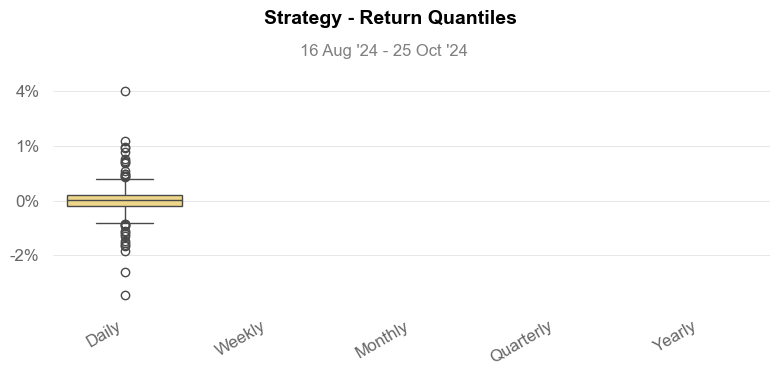

In [6]:
qs.reports.full(results_analysis['Benchmark_Returns'], title="Benchmark Portfolio Performance", rf=Riskfree_rate)

                           Strategy
-------------------------  ----------
Start Period               2024-08-16
End Period                 2024-10-25
Risk-Free Rate             0.92%
Time in Market             100.0%

Cumulative Return          2.37%
CAGR﹪                     8.8%

Sharpe                     0.13
Prob. Sharpe Ratio         54.07%
Smart Sharpe               0.11
Sortino                    0.19
Smart Sortino              0.16
Sortino/√2                 0.13
Smart Sortino/√2           0.12
Omega                      1.03

Max Drawdown               -7.33%
Longest DD Days            33
Volatility (ann.)          9.06%
Calmar                     1.2
Skew                       0.27
Kurtosis                   13.06

Expected Daily %           0.01%
Expected Monthly %         0.78%
Expected Yearly %          2.37%
Kelly Criterion            2.56%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.93%
Expected Shortfall (cVaR)  -0.93%

Max Consecutive Wins       8
Ma

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2024-08-29  2024-09-16  2024-09-30    33     -7.334912         -7.091848
2  2024-10-01  2024-10-07  2024-10-14    14     -4.841201         -4.478540
3  2024-10-22  2024-10-23  2024-10-25     4     -3.364615         -2.984448
4  2024-10-15  2024-10-16  2024-10-21     7     -2.323811         -2.219914
5  2024-08-28  2024-08-28  2024-08-28     1     -1.550252         -1.371710

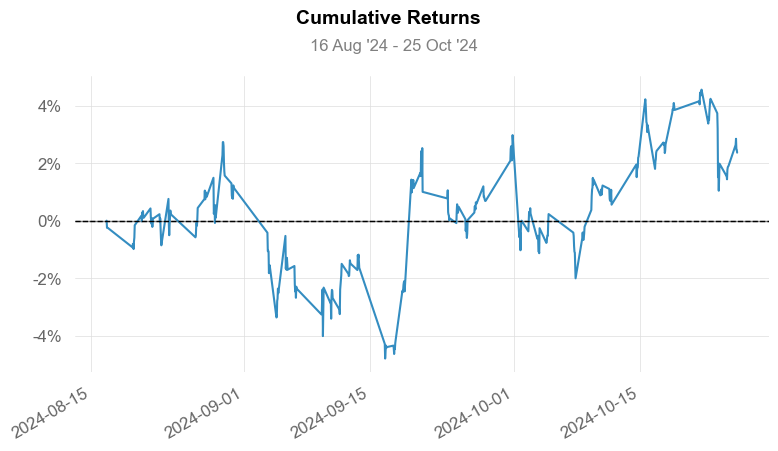

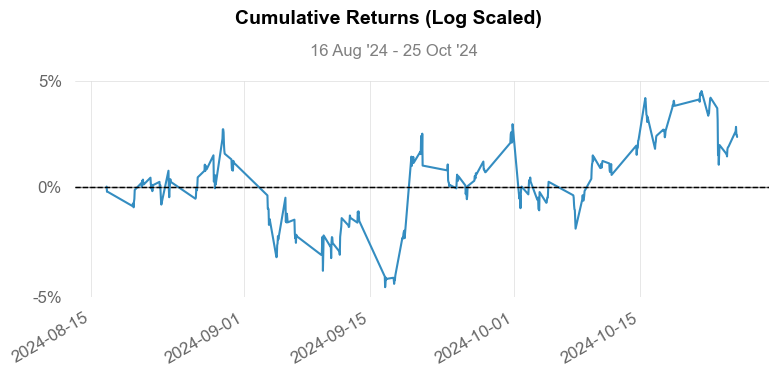

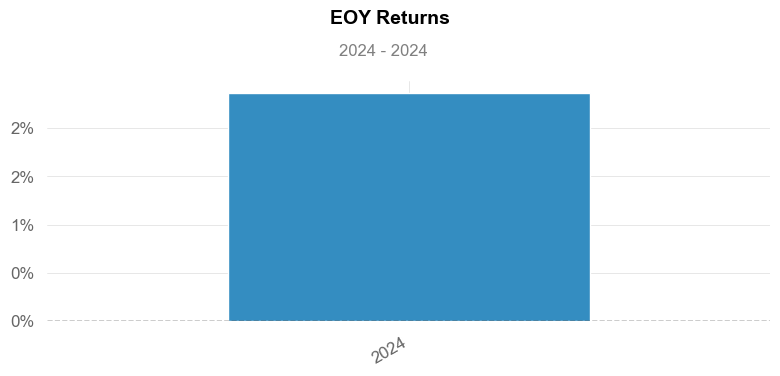

In [ ]:
qs.reports.full(results_analysis['ARIMA_Returns'], title="ARIMA Portfolio Performance", rf=Riskfree_rate)

                           Strategy
-------------------------  ----------
Start Period               2024-08-16
End Period                 2024-10-25
Risk-Free Rate             4.7%
Time in Market             59.0%

Cumulative Return          6.67%
CAGR﹪                     26.18%

Sharpe                     0.05
Prob. Sharpe Ratio         54.63%
Smart Sharpe               0.04
Sortino                    0.09
Smart Sortino              0.08
Sortino/√2                 0.06
Smart Sortino/√2           0.06
Omega                      1.01

Max Drawdown               -3.21%
Longest DD Days            14
Volatility (ann.)          5.84%
Calmar                     8.17
Skew                       4.32
Kurtosis                   44.9

Expected Daily %           0.02%
Expected Monthly %         2.18%
Expected Yearly %          6.67%
Kelly Criterion            11.87%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.59%
Expected Shortfall (cVaR)  -0.59%

Max Consecutive Wins       8
M

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2024-10-15  2024-10-25  2024-10-25    11     -3.206863         -3.114925
2  2024-08-22  2024-09-03  2024-09-05    14     -2.097068         -2.094880
3  2024-09-27  2024-10-08  2024-10-09    13     -1.989394         -1.954505
4  2024-09-06  2024-09-09  2024-09-17    12     -1.860593         -1.463933
5  2024-10-09  2024-10-11  2024-10-14     5     -1.705185         -1.200275

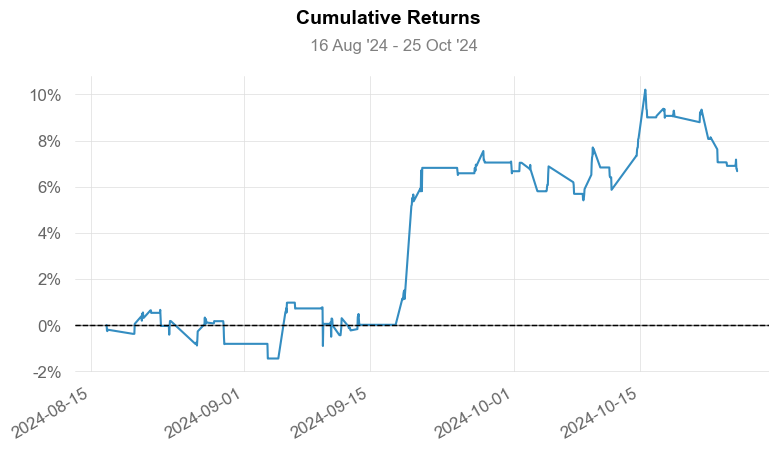

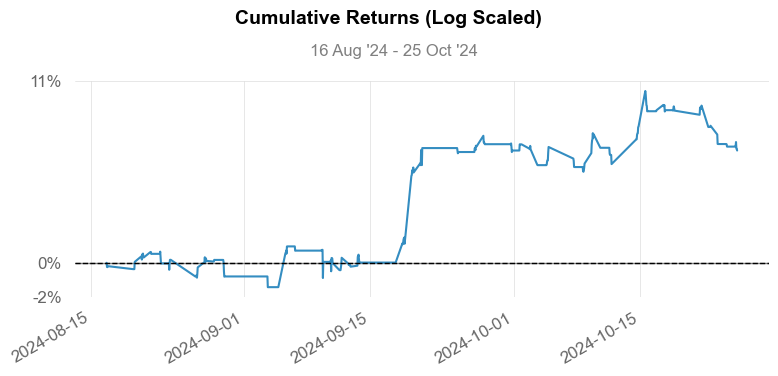

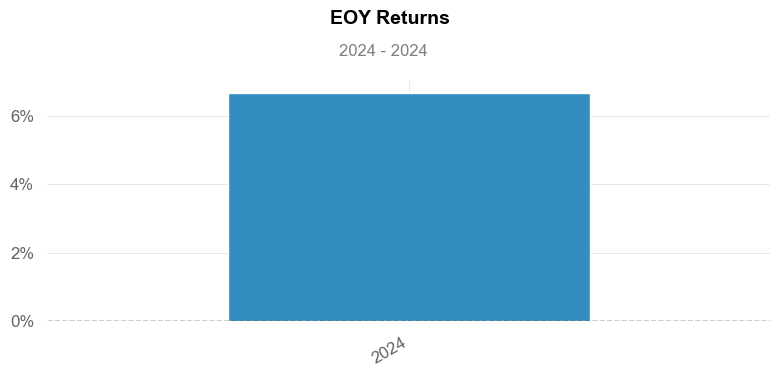

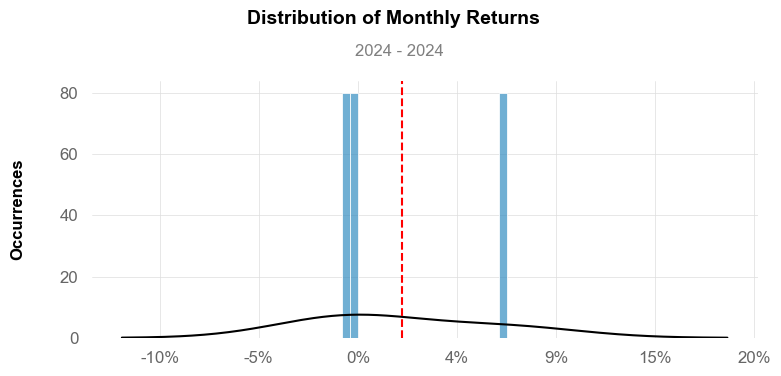

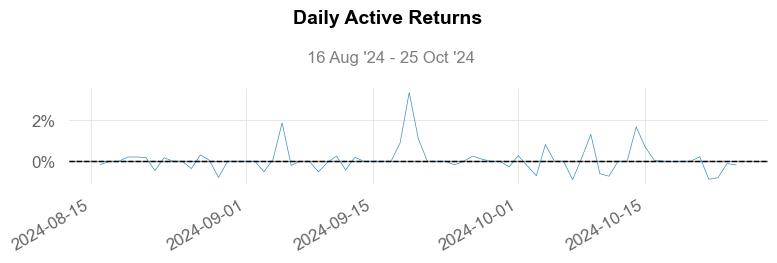

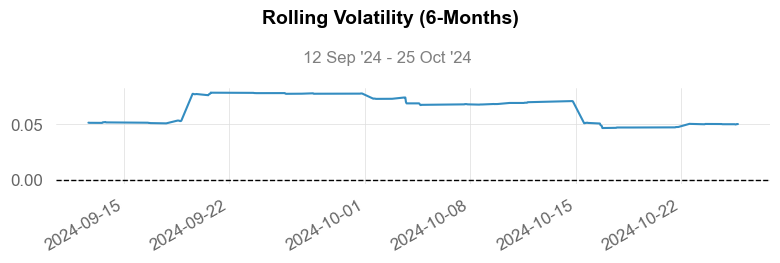

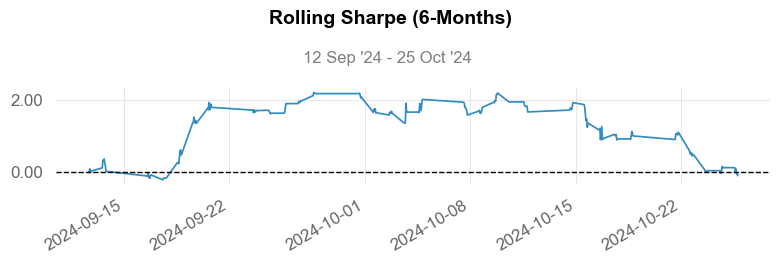

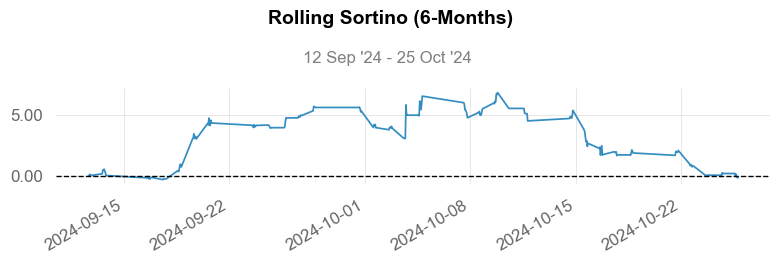

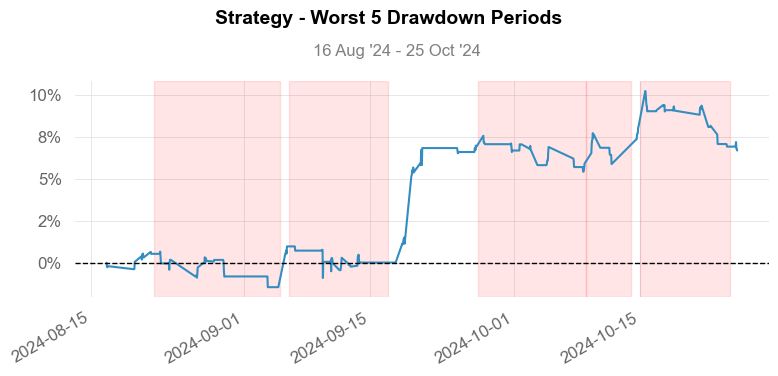

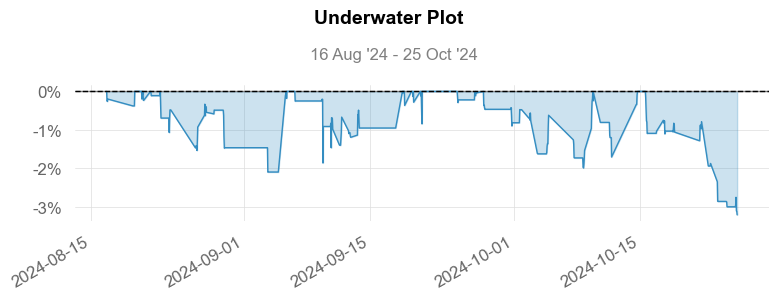

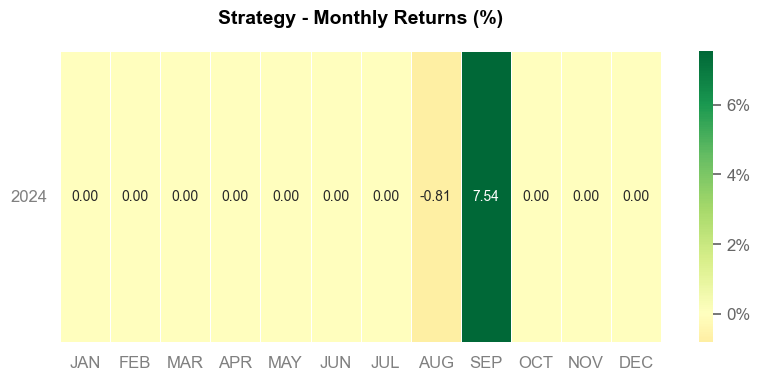

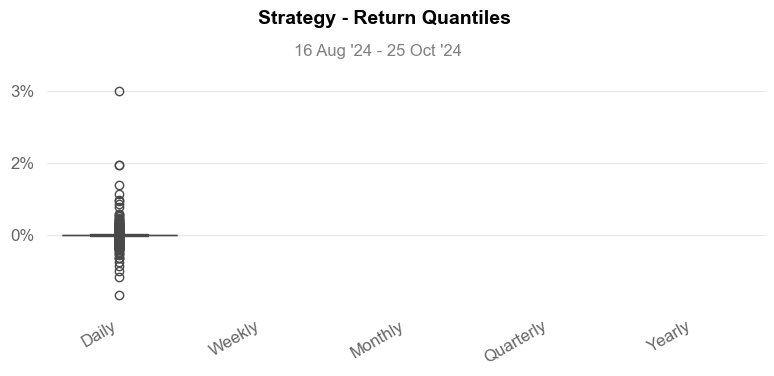

In [76]:
qs.reports.full(results_analysis['LSTM_Returns'], title="LSTM Portfolio Performance", rf=Riskfree_rate)

                           Strategy
-------------------------  ----------
Start Period               2024-08-16
End Period                 2024-10-25
Risk-Free Rate             4.7%
Time in Market             61.0%

Cumulative Return          7.22%
CAGR﹪                     28.53%

Sharpe                     0.11
Prob. Sharpe Ratio         57.79%
Smart Sharpe               0.1
Sortino                    0.21
Smart Sortino              0.19
Sortino/√2                 0.15
Smart Sortino/√2           0.13
Omega                      1.03

Max Drawdown               -3.54%
Longest DD Days            13
Volatility (ann.)          5.86%
Calmar                     8.05
Skew                       4.31
Kurtosis                   43.95

Expected Daily %           0.02%
Expected Monthly %         2.35%
Expected Yearly %          7.22%
Kelly Criterion            12.2%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.59%
Expected Shortfall (cVaR)  -0.59%

Max Consecutive Wins       8
Ma

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2024-10-15  2024-10-25  2024-10-25    11     -3.542741         -3.451122
2  2024-09-06  2024-09-09  2024-09-17    12     -1.860593         -1.463933
3  2024-09-27  2024-10-08  2024-10-09    13     -1.632830         -1.597814
4  2024-08-28  2024-09-03  2024-09-04     8     -1.621431         -1.619231
5  2024-10-09  2024-10-11  2024-10-14     5     -1.485105         -0.979064

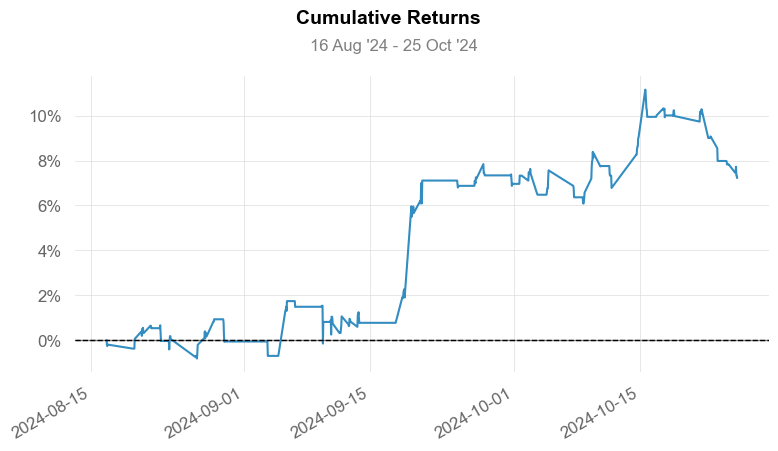

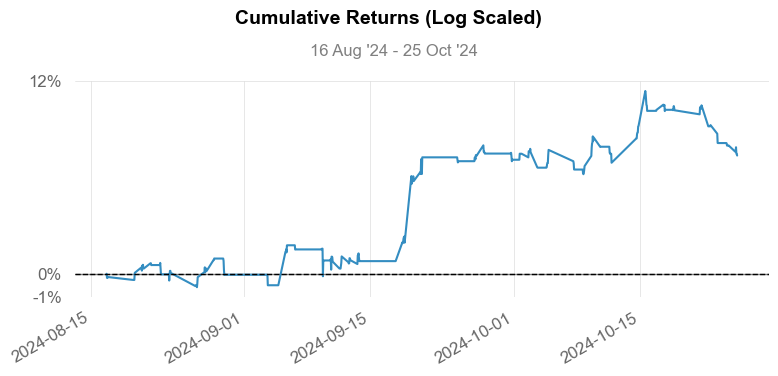

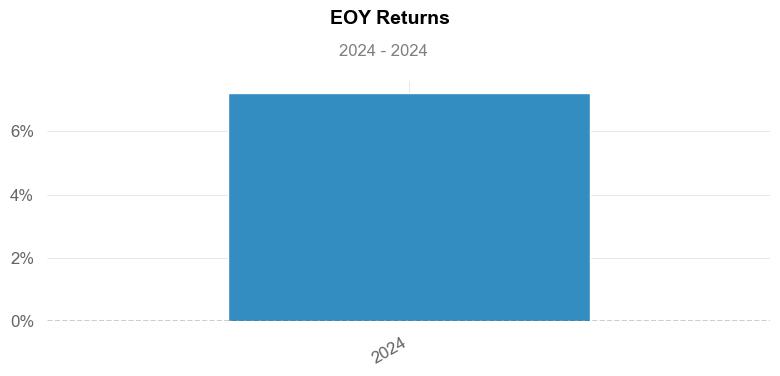

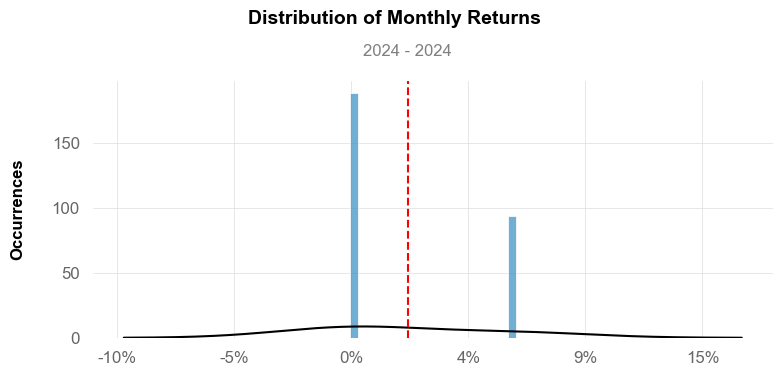

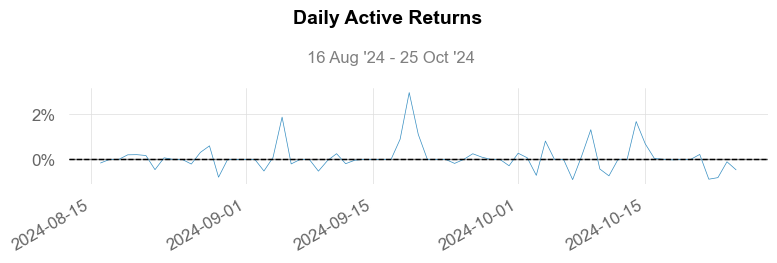

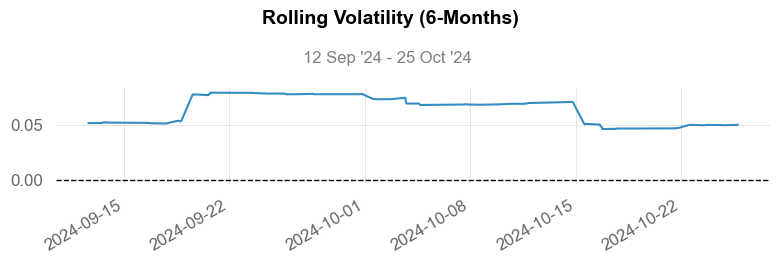

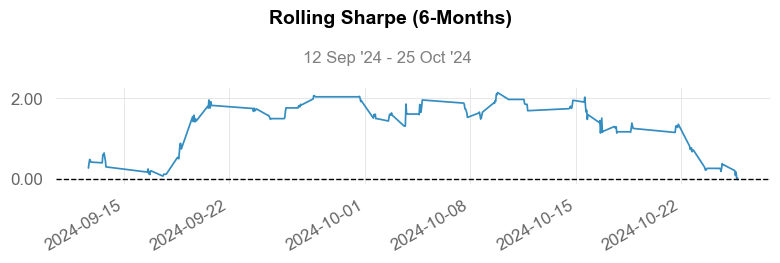

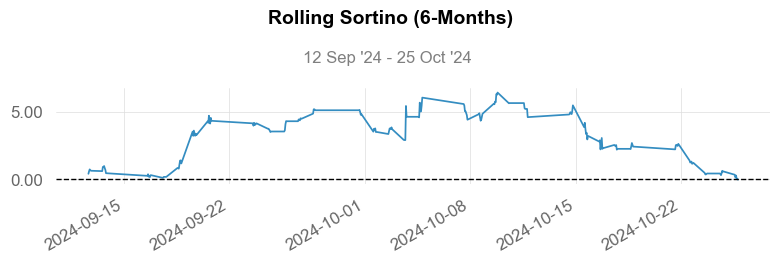

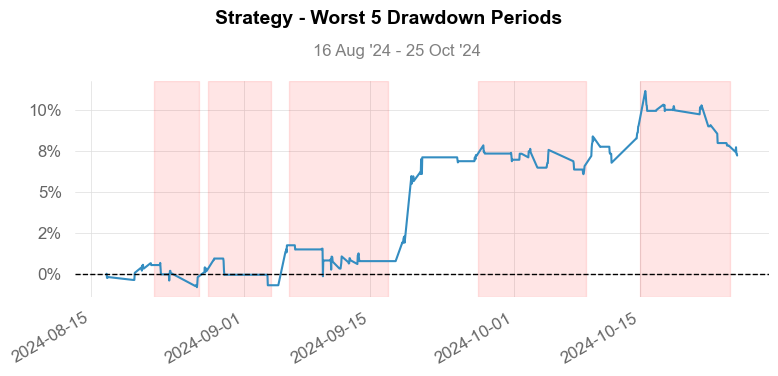

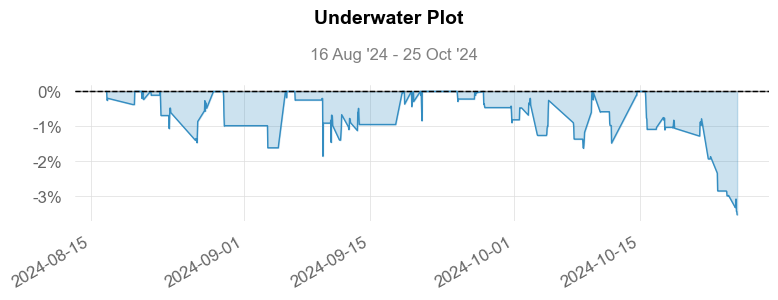

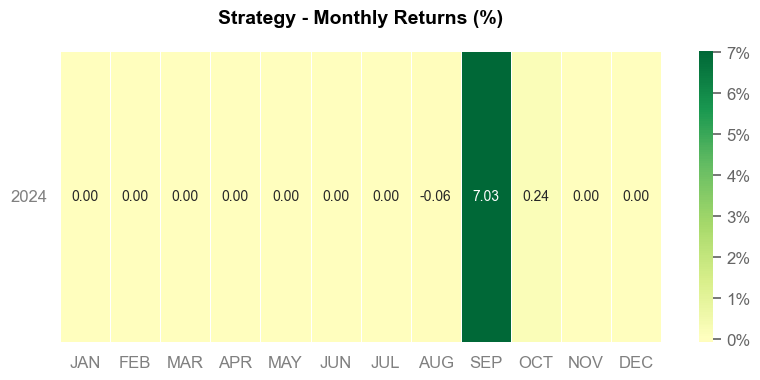

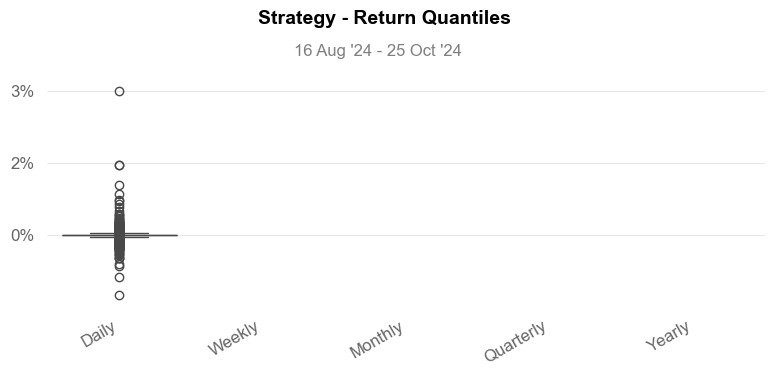

In [77]:
qs.reports.full(results_analysis['MoE_Returns'], title="MoE Portfolio Performance", rf=Riskfree_rate)